# Project T21 RNA-seq data

Project T21 RNA-seq data to Multiplier model and study differential LVs between affected (T21) and control (D21) samples.

# Load libraries/modules

In [1]:
library(biomaRt)
library(here)
library(biomaRt)
library(DESeq2)
library(tidyverse)
library(rtracklayer)
library(dplyr)
library(GenomicRanges)
library(ggpubr)
library(cowplot)
# load plier utils
source(here::here('scripts/plier_util.R'))

here() starts at /home/msubirana/Documents/pivlab/plier_recount3

Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min



Attaching package: ‘S4Vectors’


The following object is masked from ‘package:utils’:

    findMatches


The following objects are masked from ‘package:base’:

    expand.grid, I, unname


Loading required package: IRanges

Loading required p

# Load data

In [2]:
# define output nb
output_nb_path = here('output/nbs/project_T21_rnaseq_data')
dir.create(output_nb_path, showWarnings = FALSE)

counts_matrix=here::here('data/GSE151282/GSE151282_Raw_gene_counts_matrix.txt')

# multiplier model
multiplier_z = readRDS(here('data/multiplier/multiplier_model_z.rds'))
multiplier_summary = readRDS(here('data/multiplier/multiplier_model_summary.rds'))
multiplier_b = readRDS(here('data/multiplier/multiplier_model_b.rds'))
multiplier_metadata = readRDS(here('data/multiplier/multiplier_model_metadata.rds'))
multiplier_U = readRDS(here('data/multiplier/multiplier_model_u.rds'))

# TPM Normalization Process

TPM (Transcripts Per Kilobase Million) is a method for normalizing RNA sequencing data. It helps in comparing gene expression levels across different samples. The steps to compute TPM are as follows:

1. **Load the Data**: Import your gene count data into R.
2. **Calculate Gene Lengths**: Obtain or calculate the length of each gene in kilobases. This data is necessary for the normalization process.
3. **Compute Scaled Reads**: Divide each gene's read count by its length in kilobases to account for gene length and get scaled reads.
4. **Sum Scaled Reads**: Calculate the sum of all the scaled reads across all genes in a sample. This sum will be used to normalize the read counts so that they are comparable across samples.
5. **Calculate TPM**: Normalize each gene's scaled reads by the sum of scaled reads across all genes and multiply by 1,000,000. This final step adjusts for the total amount of transcript in each sample, allowing for comparisons across samples.


# GSE151282 RNA-seq analysis

- The transcriptome profile of human trisomy 21 blood cells
- Antonaros, F., Zenatelli, R., Guerri, G. et al. The transcriptome profile of human trisomy 21 blood cells. Hum Genomics 15, 25 (2021). https://doi.org/10.1186/s40246-021-00325-4
- Human blood cell RNA-Seq
- 4 T21
- 4 D21

In [3]:
gene_counts_GSE151282 <- read.table(counts_matrix, header = TRUE, sep = "\t", check.names = FALSE)
head(gene_counts_GSE151282)

,Geneid,GeneSymbol,A2_T21,A1_T21,B1_N,B2_N,A3_T21,A4_T21,B4_N,B3_N
,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,ENSG00000223972,DDX11L1,0,1,3,0,0,1,3,1
2,ENSG00000227232,WASH7P,12,56,21,6,1,1,11,3
3,ENSG00000278267,MIR6859-1,0,2,3,1,0,0,2,1
4,ENSG00000243485,MIR1302-2HG,0,0,0,0,0,0,0,0
5,ENSG00000284332,MIR1302-2,0,0,0,0,0,0,0,0
6,ENSG00000237613,FAM138A,0,0,0,1,0,0,0,0


In [4]:
gene_counts=gene_counts_GSE151282
head(gene_counts)

,Geneid,GeneSymbol,A2_T21,A1_T21,B1_N,B2_N,A3_T21,A4_T21,B4_N,B3_N
,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,ENSG00000223972,DDX11L1,0,1,3,0,0,1,3,1
2,ENSG00000227232,WASH7P,12,56,21,6,1,1,11,3
3,ENSG00000278267,MIR6859-1,0,2,3,1,0,0,2,1
4,ENSG00000243485,MIR1302-2HG,0,0,0,0,0,0,0,0
5,ENSG00000284332,MIR1302-2,0,0,0,0,0,0,0,0
6,ENSG00000237613,FAM138A,0,0,0,1,0,0,0,0


In [5]:
gtf_path <- here::here('data/GCF_000001405.38_GRCh38.p12_genomic.gtf')
tpm_gene_counts_GSE151282=tpm_normalization(gene_counts_GSE151282, gtf_path)
head(tpm_gene_counts_GSE151282)

Joining with `by = join_by(GeneSymbol)`


,A2_T21,A1_T21,B1_N,B2_N,A3_T21,A4_T21,B4_N,B3_N
DDX11L1,0.0000000,0.0894938,0.2321369,0.00000000,0.000000000,0.049095538,0.13955746,0.05185053
WASH7P,0.2340089,0.8465178,0.2744716,0.08385476,0.007722642,0.008292723,0.08643301,0.02627421
MIR6859.1,0.0000000,6.7721425,8.7830902,3.13057782,0.000000000,0.000000000,3.52018064,1.96180738
MIR1302.2HG,0.0000000,0.0000000,0.0000000,0.00000000,0.000000000,0.000000000,0.00000000,0.00000000
MIR1302.2,0.0000000,0.0000000,0.0000000,0.00000000,0.000000000,0.000000000,0.00000000,0.00000000
FAM138A,0.0000000,0.0000000,0.0000000,0.14268620,0.000000000,0.000000000,0.00000000,0.00000000


# Multiplier projection

In [6]:
multiplier_model = list('Z'=multiplier_z, 'L2'= multiplier_metadata$L2, 'B'=multiplier_b, 'U'=multiplier_U)

In [7]:
result_GetOrderedRowNormEM <- GetOrderedRowNormEM(tpm_gene_counts_GSE151282, multiplier_model)
ordered_tpm_gene_counts_GSE151282 = result_GetOrderedRowNormEM$exprs.norm.filtered
ordered_multiplier_model = result_GetOrderedRowNormEM$plier.model

head(ordered_tpm_gene_counts_GSE151282)
head(ordered_multiplier_model$Z)

Loading required package: PLIER

Loading required package: RColorBrewer

Loading required package: gplots


Attaching package: ‘gplots’


The following object is masked from ‘package:rtracklayer’:

    space


The following object is masked from ‘package:IRanges’:

    space


The following object is masked from ‘package:S4Vectors’:

    space


The following object is masked from ‘package:stats’:

    lowess


Loading required package: pheatmap

Loading required package: glmnet

Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack


The following object is masked from ‘package:S4Vectors’:

    expand


Loaded glmnet 4.1-8

Loading required package: knitr

Loading required package: rsvd

Loading required package: qvalue



,A2_T21,A1_T21,B1_N,B2_N,A3_T21,A4_T21,B4_N,B3_N
NOC2L,0.6174599,1.6425985,0.77679955,0.4719270,-0.97073166,-0.8561426,-0.79212548,-0.8897853
HES4,0.6887493,2.1251224,-0.84268842,-0.8426884,-0.53945012,-0.5170652,0.08291795,-0.1548974
ISG15,2.4165907,-0.1183297,-0.50614670,-0.1136030,-0.08082541,-0.6019605,-0.41920696,-0.5765184
AGRN,1.1376288,1.8609427,0.05741559,-0.1041626,-0.56033097,-0.7717821,-0.74987413,-0.8698373
TNFRSF18,0.5938318,2.2526853,-0.25348261,-0.6202730,-0.82341560,-0.3412662,-0.36656795,-0.4415117
TNFRSF4,0.6852642,1.7872640,-0.01884701,0.8129952,-0.84879276,-0.7458437,-0.84584812,-0.8261918


NOC2L,2.23797023,0.00000000,0.112685524,0.00000000,0.000000000,0.00000000,0,0,0.42079364,0.0000000,⋯,0.00000000,0.08177377,0.07962461,0.000000000,0,0.000000000,0.43284712,0.00000000,0.00000000,0.0000000
HES4,0.26999934,0.08490505,0.000000000,0.05744514,0.013894115,0.76790870,0,0,1.70535493,0.0000000,⋯,0.00000000,0.00000000,0.05260650,0.014124645,0,0.000000000,0.57737279,0.08543191,0.00000000,0.0000000
ISG15,0.03686669,0.00000000,0.000000000,0.04568015,0.004998977,0.00000000,0,0,0.23015827,0.1165996,⋯,0.00000000,0.00000000,0.00000000,0.018421383,0,0.003058988,0.00000000,0.00000000,0.00000000,0.0000000
AGRN,0.43266367,0.00000000,0.010172089,0.00000000,0.025733268,0.00000000,0,0,0.09382693,0.0930792,⋯,0.00000000,0.00000000,0.00000000,0.000000000,0,0.000000000,0.38517356,0.06212099,0.00000000,0.1202636
TNFRSF18,0.01226595,0.00000000,0.003937571,0.00000000,0.017390170,0.08748055,0,0,0.07813778,0.0000000,⋯,0.02974547,0.02527198,0.00000000,0.008847392,0,0.008247321,0.03988636,0.00000000,0.00000000,0.0000000
TNFRSF4,0.00000000,0.00000000,0.000000000,0.00000000,0.000000000,0.00000000,0,0,0.41229068,0.0000000,⋯,0.00000000,0.09573129,0.00000000,0.025296539,0,0.000000000,0.00000000,0.00000000,0.01924974,0.0000000


In [8]:
projection_GSE151282 <-  GetNewDataB(ordered_tpm_gene_counts_GSE151282, ordered_multiplier_model)
head(projection_GSE151282)

,A2_T21,A1_T21,B1_N,B2_N,A3_T21,A4_T21,B4_N,B3_N
"1,REACTOME_MRNA_SPLICING",-0.026318078,0.06145420,0.011525707,0.184757951,-0.01845054,-0.070357926,-0.054525362,-0.088085944
"2,SVM Monocytes",0.036208297,0.18198135,-0.032589538,-0.079208460,-0.02288641,-0.019616545,-0.033563073,-0.030325616
"3,REACTOME_TRANSMISSION_ACROSS_CHEMICAL_SYNAPSES",0.013594587,0.08547574,0.036401351,0.010737753,-0.03957537,-0.043117196,-0.020358955,-0.043157917
"4,REACTOME_NEURONAL_SYSTEM",0.002833815,0.03284135,0.040269087,-0.031094299,-0.03377510,0.015996659,-0.008314205,-0.018757312
LV 5,-0.015823665,0.04365339,0.073584457,-0.021515534,-0.04625251,-0.013057946,0.004891599,-0.025479794
LV 6,0.003273767,0.01989563,0.003527031,-0.007582424,-0.01789218,0.007342733,-0.006843828,-0.001720723


In [9]:
df_projection_GSE151282 <- data.frame(projection_GSE151282) %>%
  dplyr::mutate(LV = rownames(projection_GSE151282)) %>%
  dplyr::select(LV, everything()) %>%
  `rownames<-`(1:nrow(projection_GSE151282))

head(df_projection_GSE151282)
dim(df_projection_GSE151282)

,LV,A2_T21,A1_T21,B1_N,B2_N,A3_T21,A4_T21,B4_N,B3_N
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,"1,REACTOME_MRNA_SPLICING",-0.026318078,0.06145420,0.011525707,0.184757951,-0.01845054,-0.070357926,-0.054525362,-0.088085944
2,"2,SVM Monocytes",0.036208297,0.18198135,-0.032589538,-0.079208460,-0.02288641,-0.019616545,-0.033563073,-0.030325616
3,"3,REACTOME_TRANSMISSION_ACROSS_CHEMICAL_SYNAPSES",0.013594587,0.08547574,0.036401351,0.010737753,-0.03957537,-0.043117196,-0.020358955,-0.043157917
4,"4,REACTOME_NEURONAL_SYSTEM",0.002833815,0.03284135,0.040269087,-0.031094299,-0.03377510,0.015996659,-0.008314205,-0.018757312
5,LV 5,-0.015823665,0.04365339,0.073584457,-0.021515534,-0.04625251,-0.013057946,0.004891599,-0.025479794
6,LV 6,0.003273767,0.01989563,0.003527031,-0.007582424,-0.01789218,0.007342733,-0.006843828,-0.001720723


[1] 987   9

In [10]:
# Transpose Data for Analysis
lv_data_long <- df_projection_GSE151282 %>% 
  pivot_longer(cols = -LV, names_to = "Sample", values_to = "Value") %>% 
  mutate(Group = ifelse(str_detect(Sample, "A[0-9]_T21"), "T21", "N"))

head(lv_data_long)

LV,Sample,Value,Group
<chr>,<chr>,<dbl>,<chr>
"1,REACTOME_MRNA_SPLICING",A2_T21,-0.02631808,T21
"1,REACTOME_MRNA_SPLICING",A1_T21,0.06145420,T21
"1,REACTOME_MRNA_SPLICING",B1_N,0.01152571,N
"1,REACTOME_MRNA_SPLICING",B2_N,0.18475795,N
"1,REACTOME_MRNA_SPLICING",A3_T21,-0.01845054,T21
"1,REACTOME_MRNA_SPLICING",A4_T21,-0.07035793,T21


In [11]:
# Perform the Wilcoxon test for each LV pathway
wilcox_results <- lv_data_long %>%
  group_by(LV) %>%
  summarize(
    p_value = wilcox.test(Value ~ Group)$p.value
  )

# Adjust the p-values using the Benjamini-Hochberg method
wilcox_results <- wilcox_results %>%
  mutate(
    p_value_adj = p.adjust(p_value, method = "BH")
  )

# Display the results
head(wilcox_results)


LV,p_value,p_value_adj
<chr>,<dbl>,<dbl>
"1,REACTOME_MRNA_SPLICING",1.0000000,1
"10,SVM Macrophages M0",0.4857143,1
"101,DMAP_NKA3",0.4857143,1
"102,BIOCARTA_NFAT_PATHWAY",0.8857143,1
"110,REACTOME_MEIOSIS",0.6857143,1
"116,REACTOME_INTERFERON_ALPHA_BETA_SIGNALING",0.6857143,1


In [12]:
# Transpose Data for Analysis
lv_data_long <- df_projection_GSE151282 %>% 
  pivot_longer(cols = -LV, names_to = "Sample", values_to = "Value") %>% 
  mutate(Group = ifelse(str_detect(Sample, "A[0-9]_T21"), "T21", "N"))

# Function to Perform t-test for each LV
t_test_results <- lv_data_long %>%
  group_by(LV) %>%
  summarise(p_value = t.test(Value ~ Group)$p.value)

# Multiple Testing Correction (FDR)
t_test_results <- t_test_results %>%
  mutate(p_adjusted = p.adjust(p_value, method = "fdr"))

t_test_results %>% 
    arrange(p_value) %>% 
    head()

LV,p_value,p_adjusted
<chr>,<dbl>,<dbl>
LV 481,0.01233781,0.9970931
LV 219,0.02592792,0.9970931
LV 737,0.04010704,0.9970931
"26,SVM Macrophages M2",0.05340880,0.9970931
"707,REACTOME_PEPTIDE_CHAIN_ELONGATION",0.05978140,0.9970931
LV 281,0.06354939,0.9970931


In [13]:
df_ordered_multiplier_modelZ <- as.data.frame(as.matrix(ordered_multiplier_model$Z)) %>%
  `colnames<-`(paste0("LV", seq_len(ncol(.)))) 
head(df_ordered_multiplier_modelZ)

,LV1,LV2,LV3,LV4,LV5,LV6,LV7,LV8,LV9,LV10,⋯,LV978,LV979,LV980,LV981,LV982,LV983,LV984,LV985,LV986,LV987
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
NOC2L,2.23797023,0.00000000,0.112685524,0.00000000,0.000000000,0.00000000,0,0,0.42079364,0.0000000,⋯,0.00000000,0.08177377,0.07962461,0.000000000,0,0.000000000,0.43284712,0.00000000,0.00000000,0.0000000
HES4,0.26999934,0.08490505,0.000000000,0.05744514,0.013894115,0.76790870,0,0,1.70535493,0.0000000,⋯,0.00000000,0.00000000,0.05260650,0.014124645,0,0.000000000,0.57737279,0.08543191,0.00000000,0.0000000
ISG15,0.03686669,0.00000000,0.000000000,0.04568015,0.004998977,0.00000000,0,0,0.23015827,0.1165996,⋯,0.00000000,0.00000000,0.00000000,0.018421383,0,0.003058988,0.00000000,0.00000000,0.00000000,0.0000000
AGRN,0.43266367,0.00000000,0.010172089,0.00000000,0.025733268,0.00000000,0,0,0.09382693,0.0930792,⋯,0.00000000,0.00000000,0.00000000,0.000000000,0,0.000000000,0.38517356,0.06212099,0.00000000,0.1202636
TNFRSF18,0.01226595,0.00000000,0.003937571,0.00000000,0.017390170,0.08748055,0,0,0.07813778,0.0000000,⋯,0.02974547,0.02527198,0.00000000,0.008847392,0,0.008247321,0.03988636,0.00000000,0.00000000,0.0000000
TNFRSF4,0.00000000,0.00000000,0.000000000,0.00000000,0.000000000,0.00000000,0,0,0.41229068,0.0000000,⋯,0.00000000,0.09573129,0.00000000,0.025296539,0,0.000000000,0.00000000,0.00000000,0.01924974,0.0000000


In [14]:
df_ordered_multiplier_modelZ[c("LV26")] %>% 
    dplyr::arrange(desc(LV26)) %>% 
    head(10)

,LV26
,<dbl>
CCL18,6.342055
CCL23,6.144151
CD209,5.832267
CLEC10A,5.338751
ALOX15,5.022820
CLEC4A,4.229976
DNASE1L3,4.100035
C1QC,3.023242
CD1A,2.797564


In [15]:
head(ordered_multiplier_model$B)

,SRP000599.SRR013549,SRP000599.SRR013550,SRP000599.SRR013551,SRP000599.SRR013552,SRP000599.SRR013553,SRP000599.SRR013554,SRP000599.SRR013555,SRP000599.SRR013556,SRP000599.SRR013557,SRP000599.SRR013558,⋯,SRP035599.SRR1139372,SRP035599.SRR1139393,SRP035599.SRR1139388,SRP035599.SRR1139378,SRP035599.SRR1139399,SRP035599.SRR1139386,SRP035599.SRR1139375,SRP035599.SRR1139382,SRP035599.SRR1139356,SRP035599.SRR1139370
"1,REACTOME_MRNA_SPLICING",-0.059296689,-0.047909034,-0.049366085,-0.065078034,-0.036394186,-0.046432986,-0.040980500,-0.040068202,-0.046137392,-0.048547681,⋯,0.028219530,0.035137107,0.065077330,0.078143650,0.092361864,0.069042346,0.090913845,0.096341467,0.13111465,0.171751422
"2,SVM Monocytes",0.006212678,0.003625471,0.006604582,0.009258006,0.005061427,0.004132735,0.008950264,0.007226716,0.007240987,0.005709697,⋯,-0.050455152,-0.034501970,-0.033640290,-0.049702173,-0.037425739,-0.050069528,-0.022575052,-0.055091302,-0.05686929,-0.018072570
"3,REACTOME_TRANSMISSION_ACROSS_CHEMICAL_SYNAPSES",-0.026105335,-0.032232060,-0.020621382,-0.027598555,-0.035248076,-0.038700769,-0.032527087,-0.030592727,-0.028937277,-0.027405660,⋯,-0.028609689,-0.033449754,-0.030583001,-0.032399106,-0.029365381,-0.025405876,-0.033657228,-0.031317680,-0.03092424,-0.027868614
"4,REACTOME_NEURONAL_SYSTEM",-0.022079745,-0.008970910,-0.020341711,-0.016260213,-0.003022898,0.002442659,-0.020457842,-0.023735309,-0.021581483,-0.022477572,⋯,-0.037122216,-0.029658154,-0.036349546,-0.039253549,-0.035204624,-0.036345061,-0.034513880,-0.035925708,-0.04035837,-0.031131153
LV 5,0.007663157,0.007036176,0.006608393,0.003446311,0.006340665,0.007106127,0.007930485,0.009164026,0.008023601,0.007937586,⋯,-0.003055909,-0.004783739,-0.004352417,-0.004159541,-0.001084991,-0.001884109,-0.003561052,-0.003546184,-0.01210732,-0.001192709
LV 6,0.003014322,0.002005692,0.007768482,-0.004943417,0.019649274,0.003509484,0.008170202,0.009434190,0.007881926,0.007861974,⋯,-0.042169397,-0.051798302,-0.045170871,-0.048687711,-0.038200131,-0.046747069,-0.042864145,-0.032012738,-0.02439828,-0.062237591


In [16]:
int_lvs = c(481,
            219,
            737,
            26,
            707,
            281)

multiplier_summary %>% 
dplyr::filter(`LV index` %in% int_lvs) %>%
dplyr::filter(FDR < 0.05 & AUC > 0.7)

pathway,LV index,AUC,p-value,FDR
<chr>,<chr>,<dbl>,<dbl>,<dbl>
IRIS_DendriticCell-Control,26,0.7741243,8.082947e-14,6.226756e-12
SVM Macrophages M2,26,0.7896932,5.503019e-04,4.600780e-03
SVM Dendritic cells resting,26,0.9803279,3.743382e-09,1.062431e-07
REACTOME_PEPTIDE_CHAIN_ELONGATION,707,0.9997656,1.032655e-15,1.012472e-13
KEGG_RIBOSOME,707,0.9566363,2.047765e-13,1.472343e-11
MIPS_40S_RIBOSOMAL_SUBUNIT_CYTOPLASMIC,707,0.9977679,6.831719e-07,1.351928e-05
MIPS_RIBOSOME_CYTOPLASMIC,707,0.9995303,7.948872e-15,7.144049e-13
REACTOME_ACTIVATION_OF_THE_MRNA_UPON_BINDING_OF_THE_CAP_BINDING_COMPLEX_AND_EIFS_AND_SUBSEQUENT_BINDING_TO_43S,707,0.8645801,8.299737e-07,1.612841e-05


# GSE190125 RNA-seq analysis

- Multidimensional definition of the interferonopathy of Down syndrome and its response to JAK inhibitionGalbraith, M. D., Rachubinski, A. L., Smith, K. P., Araya, P., Waugh, K. A., Enriquez-Estrada, B., Worek, K., Granrath, R. E., Kinning, K. T., Paul Eduthan, N., Ludwig, M. P., Hsieh, E. W. Y., Sullivan, K. D., & Espinosa, J. M. (2023). Multidimensional definition of the interferonopathy of Down syndrome and its response to JAK inhibition. In Science Advances (Vol. 9, Issue 26). American Association for the Advancement of Science (AAAS). https://doi.org/10.1126/sciadv.adg6218Human
- Blood cell RNA-Seq
- T21 304
- D21 96


In [17]:
counts_matrix=here::here('data/GSE190125/GSE190125_Counts_for_GEO.txt')
raw_gene_counts_GSE190125 <- read.table(counts_matrix, header = TRUE, sep = "\t", check.names = FALSE)
head(raw_gene_counts_GSE190125)

,SampleID,EnsemblID,gene_name,chr,gene_type,raw_count
,<chr>,<chr>,<chr>,<chr>,<chr>,<int>
1,HTP0001B2,ENSG00000121410.12,A1BG,chr19,protein_coding,25
2,HTP0001B2,ENSG00000268895.6,A1BG-AS1,chr19,lncRNA,378
3,HTP0001B2,ENSG00000148584.15,A1CF,chr10,protein_coding,1
4,HTP0001B2,ENSG00000175899.14,A2M,chr12,protein_coding,6
5,HTP0001B2,ENSG00000245105.4,A2M-AS1,chr12,lncRNA,64
6,HTP0001B2,ENSG00000166535.20,A2ML1,chr12,protein_coding,0


In [18]:
gene_counts_GSE190125 <- raw_gene_counts_GSE190125 %>%
 dplyr::select(-chr, -gene_type) %>%
  pivot_wider(
    names_from = SampleID,
    values_from = raw_count,
    values_fill = list(raw_count = 0)
  ) %>%
  dplyr::select(Geneid = EnsemblID, GeneSymbol = gene_name, everything())

head(gene_counts_GSE190125)

Geneid,GeneSymbol,HTP0001B2,HTP0005A3,HTP0012A2,HTP0015A4,HTP0017A4,HTP0018B3,HTP0019B2,HTP0022B2,⋯,HTP0664A,HTP0665A,HTP0666A,HTP0667A,HTP0668A,HTP0669B,HTP0672A,HTP0676A,HTP0706A,HTP0708A
<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
ENSG00000121410.12,A1BG,25,19,13,7,28,17,23,21,⋯,6,13,7,10,28,22,18,30,10,23
ENSG00000268895.6,A1BG-AS1,378,305,275,124,240,176,469,229,⋯,363,447,225,261,391,308,226,292,253,314
ENSG00000148584.15,A1CF,1,0,1,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
ENSG00000175899.14,A2M,6,11,4,11,16,4,39,11,⋯,9,15,12,18,4,7,18,8,1,12
ENSG00000245105.4,A2M-AS1,64,77,47,113,51,55,133,64,⋯,41,23,45,93,53,61,29,97,38,78
ENSG00000166535.20,A2ML1,0,0,1,0,0,3,0,1,⋯,2,0,0,0,0,0,0,0,1,0


In [19]:
tpm_gene_counts_GSE190125=tpm_normalization(gene_counts_GSE190125, gtf_path)
head(tpm_gene_counts_GSE190125)

Joining with `by = join_by(GeneSymbol)`


,HTP0001B2,HTP0005A3,HTP0012A2,HTP0015A4,HTP0017A4,HTP0018B3,HTP0019B2,HTP0022B2,HTP0023A2,HTP0025A3,⋯,HTP0664A,HTP0665A,HTP0666A,HTP0667A,HTP0668A,HTP0669B,HTP0672A,HTP0676A,HTP0706A,HTP0708A
A1BG,1.213548628,0.74541369,0.599729304,0.32731643,1.3535745,0.94879940,0.6912469,1.097659107,0.6766134,0.27325337,⋯,0.255005402,0.52592489,0.28917116,0.4338034,1.0180578,1.07863098,0.66926351,1.31704224,0.422119153,1.10667053
A1BG.AS1,38.222498659,24.92606386,26.427416614,12.07818145,24.1682646,20.46200787,29.3621799,24.934104324,37.2498378,16.60207704,⋯,32.137704564,37.67020602,19.36197036,23.5854179,29.6142852,31.45654523,17.50423671,26.70369761,22.246704141,31.47242852
A1CF,0.003766156,0.00000000,0.003579259,0.00000000,0.0000000,0.00000000,0.0000000,0.000000000,0.0000000,0.00000000,⋯,0.000000000,0.00000000,0.00000000,0.0000000,0.0000000,0.00000000,0.00000000,0.00000000,0.000000000,0.00000000
A2M,0.040175335,0.05952886,0.025454407,0.07095019,0.1066928,0.03079474,0.1616818,0.079310732,0.1199986,0.03769264,⋯,0.052763272,0.08370718,0.06838003,0.1077101,0.0200616,0.04734121,0.09231839,0.04844618,0.005822723,0.07964579
A2M.AS1,7.224822540,7.02529435,5.042429225,12.28791629,5.7335597,7.13868477,9.2958055,7.779616698,10.7898108,6.35470746,⋯,4.052397341,2.16390527,4.32314182,9.3822274,4.4814680,6.95520729,2.50756773,9.90330650,3.730342348,8.72800822
A2ML1,0.000000000,0.00000000,0.004770096,0.00000000,0.0000000,0.01731259,0.0000000,0.005404598,0.0000000,0.00000000,⋯,0.008789078,0.00000000,0.00000000,0.0000000,0.0000000,0.00000000,0.00000000,0.00000000,0.004364659,0.00000000


In [20]:
path_metadata_GSE190125 <- here::here('data/GSE190125/metadata_GSE190125.csv')
metadata_GSE190125 <- read.csv(path_metadata_GSE190125)
colnames(metadata_GSE190125) <- c('Group', 'Sample')	
head(metadata_GSE190125)

,Group,Sample
,<chr>,<chr>
1,Control,HTP0001B2
2,Control,HTP0018B3
3,Control,HTP0019B2
4,Control,HTP0022B2
5,Control,HTP0026B2
6,Control,HTP0034B3


In [21]:
result_GetOrderedRowNormEM <- GetOrderedRowNormEM(tpm_gene_counts_GSE190125, multiplier_model)
ordered_tpm_gene_counts_GSE190125 = result_GetOrderedRowNormEM$exprs.norm.filtered
ordered_multiplier_model = result_GetOrderedRowNormEM$plier.model

head(ordered_tpm_gene_counts_GSE190125)
head(ordered_multiplier_model$Z)

,HTP0001B2,HTP0005A3,HTP0012A2,HTP0015A4,HTP0017A4,HTP0018B3,HTP0019B2,HTP0022B2,HTP0023A2,HTP0025A3,⋯,HTP0664A,HTP0665A,HTP0666A,HTP0667A,HTP0668A,HTP0669B,HTP0672A,HTP0676A,HTP0706A,HTP0708A
A2M,-0.4511689,-0.1121165,-0.70906338,0.08797261,0.7141443,-0.61550661,1.6774901,0.2344402,0.94724677,-0.4946629,⋯,-0.2306421,0.31146115,0.04294625,0.7319665,-0.8035395,-0.32563071,0.46232009,-0.3062728,-1.0529889,0.24031009
AAAS,0.3376371,1.0648374,-0.06201599,-0.18344067,0.9659808,0.05470101,-0.2310186,0.7896222,0.12996639,-0.2394220,⋯,0.6582486,0.18318387,-1.35183952,1.8328960,-0.1709499,-0.31432687,-0.52037981,0.8108448,-2.1157752,-0.09934423
AANAT,-1.4554673,0.2966210,0.08973520,-0.15031256,0.9733166,-1.45546730,1.3967099,0.2952728,-0.10648950,1.5953609,⋯,-1.4554673,0.80294176,0.15880654,0.4818698,-0.8465506,0.46042231,-0.21009809,-1.2103914,0.4296886,-0.91825897
AARS2,1.1039520,0.9154455,0.12338505,0.11105603,1.6129110,2.20735639,1.3347524,0.8589173,0.54012373,0.1849736,⋯,-1.1581949,0.30381741,-1.69540470,-0.1754602,-0.1955963,0.24331049,-0.46444298,0.2657842,-2.6609143,-0.20380117
AASDH,1.5545598,0.1122126,0.60163764,-0.39864727,0.1236081,3.99705317,1.0888981,0.6393445,-0.01836834,-0.4344999,⋯,-0.9585186,0.10753736,-1.71853439,-0.6221674,-0.3253660,0.05238675,0.25894594,1.0900112,-0.9881737,0.46889283
AASDHPPT,1.1817751,0.9033926,0.55218418,0.15202891,0.5411069,1.92994592,1.2591415,1.2224936,0.11838671,0.2378716,⋯,-0.9988919,0.09097001,-1.55073646,-0.7502916,-0.3657913,0.65232039,0.09142593,1.4709059,-0.7294011,0.93533470


A2M,0.000000000,0.000000000,0.00000000,0.07842750,0,0.0000000,0.0000000,0.04677228,0.0000000,0.01103290,⋯,0.01091000,0.00000000,0.05286944,0.012748534,0.0000000,0.01398231,0.15224090,0.00000000,0.0000000,0.10888358
AAAS,0.271162234,0.000000000,0.00000000,0.00000000,0,0.0000000,0.0000000,0.00000000,1.5133366,0.00000000,⋯,0.00000000,0.00000000,0.00000000,0.001385031,0.0000000,0.00000000,0.71189565,0.03053447,0.4471055,0.42468522
AANAT,0.005098885,0.308496909,0.02881539,0.00000000,0,0.0000000,0.3717253,0.00000000,0.1352375,0.00000000,⋯,0.11716299,0.01881498,0.00000000,0.193141835,0.0000000,0.04040077,0.18043565,0.00000000,0.0000000,0.04206449
AARS2,1.008156895,0.000000000,0.19742406,0.02483182,0,0.5708101,0.0000000,0.22867460,0.0000000,0.11624346,⋯,0.00000000,0.00000000,0.15334499,0.000000000,0.0000000,0.00000000,1.00457811,0.01447016,0.0000000,0.00000000
AASDH,0.000000000,0.006472519,0.00000000,0.00000000,0,0.0000000,0.0000000,0.00000000,0.0000000,0.01099555,⋯,0.00000000,0.00000000,0.00000000,0.031715715,0.0000000,0.00000000,0.02667058,0.04913808,0.0000000,0.00000000
AASDHPPT,0.034291461,0.000000000,0.12332561,0.39525630,0,0.1156743,0.0000000,0.00000000,0.0000000,0.00000000,⋯,0.07064013,0.00000000,0.01796876,0.000000000,0.1185511,0.00000000,0.00000000,0.00000000,0.0000000,0.00000000


In [22]:
projection_GSE190125 <-  GetNewDataB(ordered_tpm_gene_counts_GSE190125, ordered_multiplier_model)
head(projection_GSE190125)

,HTP0001B2,HTP0005A3,HTP0012A2,HTP0015A4,HTP0017A4,HTP0018B3,HTP0019B2,HTP0022B2,HTP0023A2,HTP0025A3,⋯,HTP0664A,HTP0665A,HTP0666A,HTP0667A,HTP0668A,HTP0669B,HTP0672A,HTP0676A,HTP0706A,HTP0708A
"1,REACTOME_MRNA_SPLICING",-0.06099632,-0.01430609,-0.03130548,-0.074037007,-0.048863872,-0.114502320,-0.11421761,-0.04892442,0.059415268,-0.060560160,⋯,0.080103354,0.017802191,0.04655742,0.15552108,0.051443243,-0.002789900,-0.11195683,-0.103051713,-0.21621076,-0.02468260
"2,SVM Monocytes",-0.08146227,-0.05536597,-0.02972342,-0.039475088,-0.110519728,0.009648965,0.13449292,-0.09065066,-0.104384092,-0.053987093,⋯,0.063808707,0.214577677,0.06508193,-0.10209963,-0.015714285,0.076125180,-0.03852608,-0.088829773,0.13580746,-0.04390065
"3,REACTOME_TRANSMISSION_ACROSS_CHEMICAL_SYNAPSES",-0.02262647,0.04484774,0.03568434,-0.024717313,0.027683259,-0.015442372,-0.03803203,0.02723657,0.052669709,-0.009335362,⋯,-0.007349750,-0.051454897,0.01547555,0.06168419,-0.052080550,-0.018102595,-0.10253309,-0.049551978,-0.09978477,-0.04098150
"4,REACTOME_NEURONAL_SYSTEM",0.05196313,0.06577709,0.04380500,0.040477015,0.009822520,0.180213572,0.12401270,0.06206372,0.018866738,0.001024812,⋯,-0.055041745,-0.029739440,-0.05490456,-0.04396545,-0.005205959,-0.008701111,-0.04489926,0.073023994,-0.01055307,-0.03018856
LV 5,0.04947318,0.01245486,-0.02527954,-0.003544312,-0.006318418,0.070618180,0.04279276,0.02319721,0.008408280,-0.009294967,⋯,-0.009392844,-0.021003309,-0.03397902,0.04592781,-0.032247435,0.049246856,0.04562237,-0.015651993,-0.01902293,-0.02628829
LV 6,0.01980925,0.01853340,0.02602953,0.008319347,-0.001567239,0.055275479,0.03312572,0.08031698,-0.001628834,-0.027174191,⋯,-0.003010193,-0.000987795,0.02034803,0.01559351,0.011894298,0.018546133,0.01709347,-0.007142013,0.01443277,-0.02684721


In [23]:
df_projection_GSE190125 <- data.frame(projection_GSE190125)

In [24]:
saveRDS(df_projection_GSE190125, file.path(output_nb_path, 'projection_GSE190125.rds'))

In [25]:
library(reticulate)

save_as_pickle <- function(object, filename, save_directory) {
  full_path <- file.path(save_directory, filename)
  py_save_object(r_to_py(object), full_path)
}

save_as_pickle(df_projection_GSE190125, 'projection_GSE190125.pkl', output_nb_path)


Attaching package: ‘reticulate’


The following object is masked from ‘package:rtracklayer’:

    import




In [26]:
df_projection_GSE190125 <- data.frame(projection_GSE190125) %>%
  dplyr::mutate(LV = rownames(projection_GSE190125)) %>%
  dplyr::select(LV, everything()) %>%
  `rownames<-`(1:nrow(projection_GSE190125))

head(df_projection_GSE190125)

,LV,HTP0001B2,HTP0005A3,HTP0012A2,HTP0015A4,HTP0017A4,HTP0018B3,HTP0019B2,HTP0022B2,HTP0023A2,⋯,HTP0664A,HTP0665A,HTP0666A,HTP0667A,HTP0668A,HTP0669B,HTP0672A,HTP0676A,HTP0706A,HTP0708A
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,"1,REACTOME_MRNA_SPLICING",-0.06099632,-0.01430609,-0.03130548,-0.074037007,-0.048863872,-0.114502320,-0.11421761,-0.04892442,0.059415268,⋯,0.080103354,0.017802191,0.04655742,0.15552108,0.051443243,-0.002789900,-0.11195683,-0.103051713,-0.21621076,-0.02468260
2,"2,SVM Monocytes",-0.08146227,-0.05536597,-0.02972342,-0.039475088,-0.110519728,0.009648965,0.13449292,-0.09065066,-0.104384092,⋯,0.063808707,0.214577677,0.06508193,-0.10209963,-0.015714285,0.076125180,-0.03852608,-0.088829773,0.13580746,-0.04390065
3,"3,REACTOME_TRANSMISSION_ACROSS_CHEMICAL_SYNAPSES",-0.02262647,0.04484774,0.03568434,-0.024717313,0.027683259,-0.015442372,-0.03803203,0.02723657,0.052669709,⋯,-0.007349750,-0.051454897,0.01547555,0.06168419,-0.052080550,-0.018102595,-0.10253309,-0.049551978,-0.09978477,-0.04098150
4,"4,REACTOME_NEURONAL_SYSTEM",0.05196313,0.06577709,0.04380500,0.040477015,0.009822520,0.180213572,0.12401270,0.06206372,0.018866738,⋯,-0.055041745,-0.029739440,-0.05490456,-0.04396545,-0.005205959,-0.008701111,-0.04489926,0.073023994,-0.01055307,-0.03018856
5,LV 5,0.04947318,0.01245486,-0.02527954,-0.003544312,-0.006318418,0.070618180,0.04279276,0.02319721,0.008408280,⋯,-0.009392844,-0.021003309,-0.03397902,0.04592781,-0.032247435,0.049246856,0.04562237,-0.015651993,-0.01902293,-0.02628829
6,LV 6,0.01980925,0.01853340,0.02602953,0.008319347,-0.001567239,0.055275479,0.03312572,0.08031698,-0.001628834,⋯,-0.003010193,-0.000987795,0.02034803,0.01559351,0.011894298,0.018546133,0.01709347,-0.007142013,0.01443277,-0.02684721


In [27]:
# Transpose Data for Analysis
lv_data_long <- df_projection_GSE190125 %>% 
  pivot_longer(cols = -LV, names_to = "Sample", values_to = "Value") %>% 
    dplyr::left_join(metadata_GSE190125)

# Function to Perform t-test for each LV
t_test_results <- lv_data_long %>%
  group_by(LV) %>%
  summarise(p_value = t.test(Value ~ Group)$p.value)

# Multiple Testing Correction (FDR)
t_test_results <- t_test_results %>%
  mutate(p_adjusted = p.adjust(p_value, method = "fdr"))

sig_t_test_results <-  t_test_results %>% 
    arrange(p_value) %>% 
    dplyr::filter(p_adjusted < 0.05)

head(sig_t_test_results)

Joining with `by = join_by(Sample)`


LV,p_value,p_adjusted
<chr>,<dbl>,<dbl>
LV 338,5.498213e-38,5.426737e-35
LV 967,1.724775e-30,8.511766e-28
LV 875,4.760238e-30,1.566118e-27
LV 149,2.370182e-28,4.484793e-26
LV 439,2.952776e-28,4.484793e-26
LV 52,3.042914e-28,4.484793e-26


In [28]:
# Perform the Wilcoxon test for each LV pathway
wilcox_results <- lv_data_long %>%
  group_by(LV) %>%
  summarize(
    p_value = wilcox.test(Value ~ Group)$p.value
  )

# Adjust the p-values using the Benjamini-Hochberg method
wilcox_results <- wilcox_results %>%
  mutate(
    p_value_adj = p.adjust(p_value, method = "BH")) %>% 
    arrange(p_value_adj)

# Display the results
head(wilcox_results)


LV,p_value,p_value_adj
<chr>,<dbl>,<dbl>
LV 338,3.220013e-33,3.178153e-30
LV 149,1.973524e-31,9.739340e-29
LV 239,2.546223e-30,8.377073e-28
LV 967,8.166181e-29,2.015005e-26
LV 439,7.351486e-28,1.451183e-25
LV 869,6.950850e-27,1.143415e-24


In [29]:
filtered_wilcox_results <- wilcox_results %>% 
dplyr::filter(p_value_adj < 0.05)
dim(filtered_wilcox_results)
saveRDS(filtered_wilcox_results, file.path(output_nb_path, 'projection_GSE190125_filtered_wilcox_results.rds'))

[1] 719   3

In [30]:
top_int_lvs <-  str_extract(sig_t_test_results$LV, "\\d+")
top_int_lvs <- unique(top_int_lvs)
head(top_int_lvs)

[1] "338" "967" "875" "149" "439" "52"

In [31]:
multiplier_summary %>% 
dplyr::filter(`LV index` %in% top_int_lvs) %>%
dplyr::filter(FDR < 0.05 & AUC > 0.7)

pathway,LV index,AUC,p-value,FDR
<chr>,<chr>,<dbl>,<dbl>,<dbl>
REACTOME_TRANSMISSION_ACROSS_CHEMICAL_SYNAPSES,3,0.7823614,9.532254e-08,2.164323e-06
PID_RAC1_REG_PATHWAY,4,0.7551066,4.924915e-03,2.649138e-02
PID_ERBB1_INTERNALIZATION_PATHWAY,4,0.7444768,6.725439e-03,3.397370e-02
IRIS_Neutrophil-Resting,7,0.7006335,6.673189e-11,2.937565e-09
PID_IL8CXCR2_PATHWAY,7,0.7242235,1.057905e-02,4.928513e-02
REACTOME_IMMUNOREGULATORY_INTERACTIONS_BETWEEN_A_LYMPHOID_AND_A_NON_LYMPHOID_CELL,7,0.7075224,2.881284e-03,1.731178e-02
KEGG_PPAR_SIGNALING_PATHWAY,8,0.7898987,2.221298e-04,2.170448e-03
IRIS_Monocyte-Day1,10,0.7172650,6.596666e-11,2.937565e-09
IRIS_Monocyte-Day7,10,0.7754324,1.400212e-15,1.313155e-13


In [32]:
multiplier_summary %>% 
dplyr::filter(`LV index` %in% top_int_lvs) %>%
dplyr::filter(FDR < 0.05 & AUC > 0.7) %>% 
arrange(match(`LV index`, top_int_lvs))

pathway,LV index,AUC,p-value,FDR
<chr>,<chr>,<dbl>,<dbl>,<dbl>
PID_AR_NONGENOMIC_PATHWAY,338,0.7515377,1.037288e-02,4.874576e-02
REACTOME_FORMATION_OF_THE_TERNARY_COMPLEX_AND_SUBSEQUENTLY_THE_43S_COMPLEX,310,0.7516784,1.039316e-03,7.901466e-03
DMAP_MEGA2,264,0.8578451,5.927467e-06,9.332515e-05
REACTOME_CHROMOSOME_MAINTENANCE,92,0.7345132,5.753136e-05,6.856085e-04
REACTOME_INTERFERON_ALPHA_BETA_SIGNALING,749,0.7697398,2.055836e-03,1.368654e-02
REACTOME_COLLAGEN_FORMATION,671,0.8873401,5.995466e-06,9.371174e-05
REACTOME_EXTRACELLULAR_MATRIX_ORGANIZATION,671,0.9817055,3.625550e-11,1.777343e-09
IRIS_Monocyte-Day1,10,0.7172650,6.596666e-11,2.937565e-09
IRIS_Monocyte-Day7,10,0.7754324,1.400212e-15,1.313155e-13


In [33]:
lv_index_vector <- multiplier_summary %>%
  dplyr::filter(`LV index` %in% top_int_lvs) %>%
  dplyr::filter(FDR < 0.05 & AUC > 0.7) %>%
  arrange(match(`LV index`, top_int_lvs)) %>%
  dplyr::select(`LV index`) %>%
  unique() %>%
  dplyr::pull(`LV index`)

lv_index_vector <- c(lv_index_vector)
lv_index_vector<-  as.numeric(lv_index_vector)
first_10_lv_indices <- c(lv_index_vector[1:10])

first_10_lv_indices

[1] 338 310 264  92 749 671  10 898  81 928

In [34]:
data.frame(multiplier_model$Z)%>% 
    dplyr::select(X898) %>%
    dplyr::mutate(X898=as.numeric(X898)) %>%  
    dplyr::arrange(desc(X898)) %>% 
    dplyr::filter(X898 > 1) %>% 
    rownames() %>% 
    print()

 [1] "NAPSB"     "FCRL5"     "IL4R"      "BLK"       "BMF"       "FCRL2"    
 [7] "LILRA4"    "IGHM"      "CD37"      "CD79A"     "SPIB"      "CARD11"   
[13] "FCRLA"     "CNR2"      "BTLA"      "BCL2"      "FCRL1"     "FAM129C"  
[19] "PAX5"      "GGA2"      "SH3BP5"    "KCNN4"     "IL24"      "FCER2"    
[25] "KLHL14"    "CD74"      "SLC9A7"    "IRF8"      "NFATC1"    "ARHGAP44" 
[31] "CBFA2T3"   "KLF8"      "IKZF3"     "PNOC"      "PLEKHG1"   "CD19"     
[37] "P2RY10"    "KIAA0040"  "SYK"       "ST6GAL1"   "CXCR4"     "FCGR2B"   
[43] "APOBEC3G"  "MAP3K14"   "SEMA4B"    "CD27"      "MAP3K1"    "LAPTM5"   
[49] "CD79B"     "TLR9"      "SPOCK2"    "RALGPS2"   "RBM38"     "ZBTB32"   
[55] "CIITA"     "GRB2"      "C11orf80"  "PRKCE"     "IL10RA"    "WDR11"    
[61] "ABCA6"     "TNFRSF13C" "RHOBTB2"   "POU2F2"    "ADAM28"    "SP140"    
[67] "ARHGAP17"  "RHOH"      "CHST2"     "ICOSLG"    "CXCR5"     "PRKCB"    
[73] "OSBPL10"   "ZFPM1"     "TADA2B"    "RAPGEF1"  


In [35]:
head(ordered_multiplier_model$B)

,SRP000599.SRR013549,SRP000599.SRR013550,SRP000599.SRR013551,SRP000599.SRR013552,SRP000599.SRR013553,SRP000599.SRR013554,SRP000599.SRR013555,SRP000599.SRR013556,SRP000599.SRR013557,SRP000599.SRR013558,⋯,SRP035599.SRR1139372,SRP035599.SRR1139393,SRP035599.SRR1139388,SRP035599.SRR1139378,SRP035599.SRR1139399,SRP035599.SRR1139386,SRP035599.SRR1139375,SRP035599.SRR1139382,SRP035599.SRR1139356,SRP035599.SRR1139370
"1,REACTOME_MRNA_SPLICING",-0.059296689,-0.047909034,-0.049366085,-0.065078034,-0.036394186,-0.046432986,-0.040980500,-0.040068202,-0.046137392,-0.048547681,⋯,0.028219530,0.035137107,0.065077330,0.078143650,0.092361864,0.069042346,0.090913845,0.096341467,0.13111465,0.171751422
"2,SVM Monocytes",0.006212678,0.003625471,0.006604582,0.009258006,0.005061427,0.004132735,0.008950264,0.007226716,0.007240987,0.005709697,⋯,-0.050455152,-0.034501970,-0.033640290,-0.049702173,-0.037425739,-0.050069528,-0.022575052,-0.055091302,-0.05686929,-0.018072570
"3,REACTOME_TRANSMISSION_ACROSS_CHEMICAL_SYNAPSES",-0.026105335,-0.032232060,-0.020621382,-0.027598555,-0.035248076,-0.038700769,-0.032527087,-0.030592727,-0.028937277,-0.027405660,⋯,-0.028609689,-0.033449754,-0.030583001,-0.032399106,-0.029365381,-0.025405876,-0.033657228,-0.031317680,-0.03092424,-0.027868614
"4,REACTOME_NEURONAL_SYSTEM",-0.022079745,-0.008970910,-0.020341711,-0.016260213,-0.003022898,0.002442659,-0.020457842,-0.023735309,-0.021581483,-0.022477572,⋯,-0.037122216,-0.029658154,-0.036349546,-0.039253549,-0.035204624,-0.036345061,-0.034513880,-0.035925708,-0.04035837,-0.031131153
LV 5,0.007663157,0.007036176,0.006608393,0.003446311,0.006340665,0.007106127,0.007930485,0.009164026,0.008023601,0.007937586,⋯,-0.003055909,-0.004783739,-0.004352417,-0.004159541,-0.001084991,-0.001884109,-0.003561052,-0.003546184,-0.01210732,-0.001192709
LV 6,0.003014322,0.002005692,0.007768482,-0.004943417,0.019649274,0.003509484,0.008170202,0.009434190,0.007881926,0.007861974,⋯,-0.042169397,-0.051798302,-0.045170871,-0.048687711,-0.038200131,-0.046747069,-0.042864145,-0.032012738,-0.02439828,-0.062237591


Warning message in max(plierRes$summary[plierRes$summary[, 5] < fdr.cutoff, 4]):
“no non-missing arguments to max; returning -Inf”


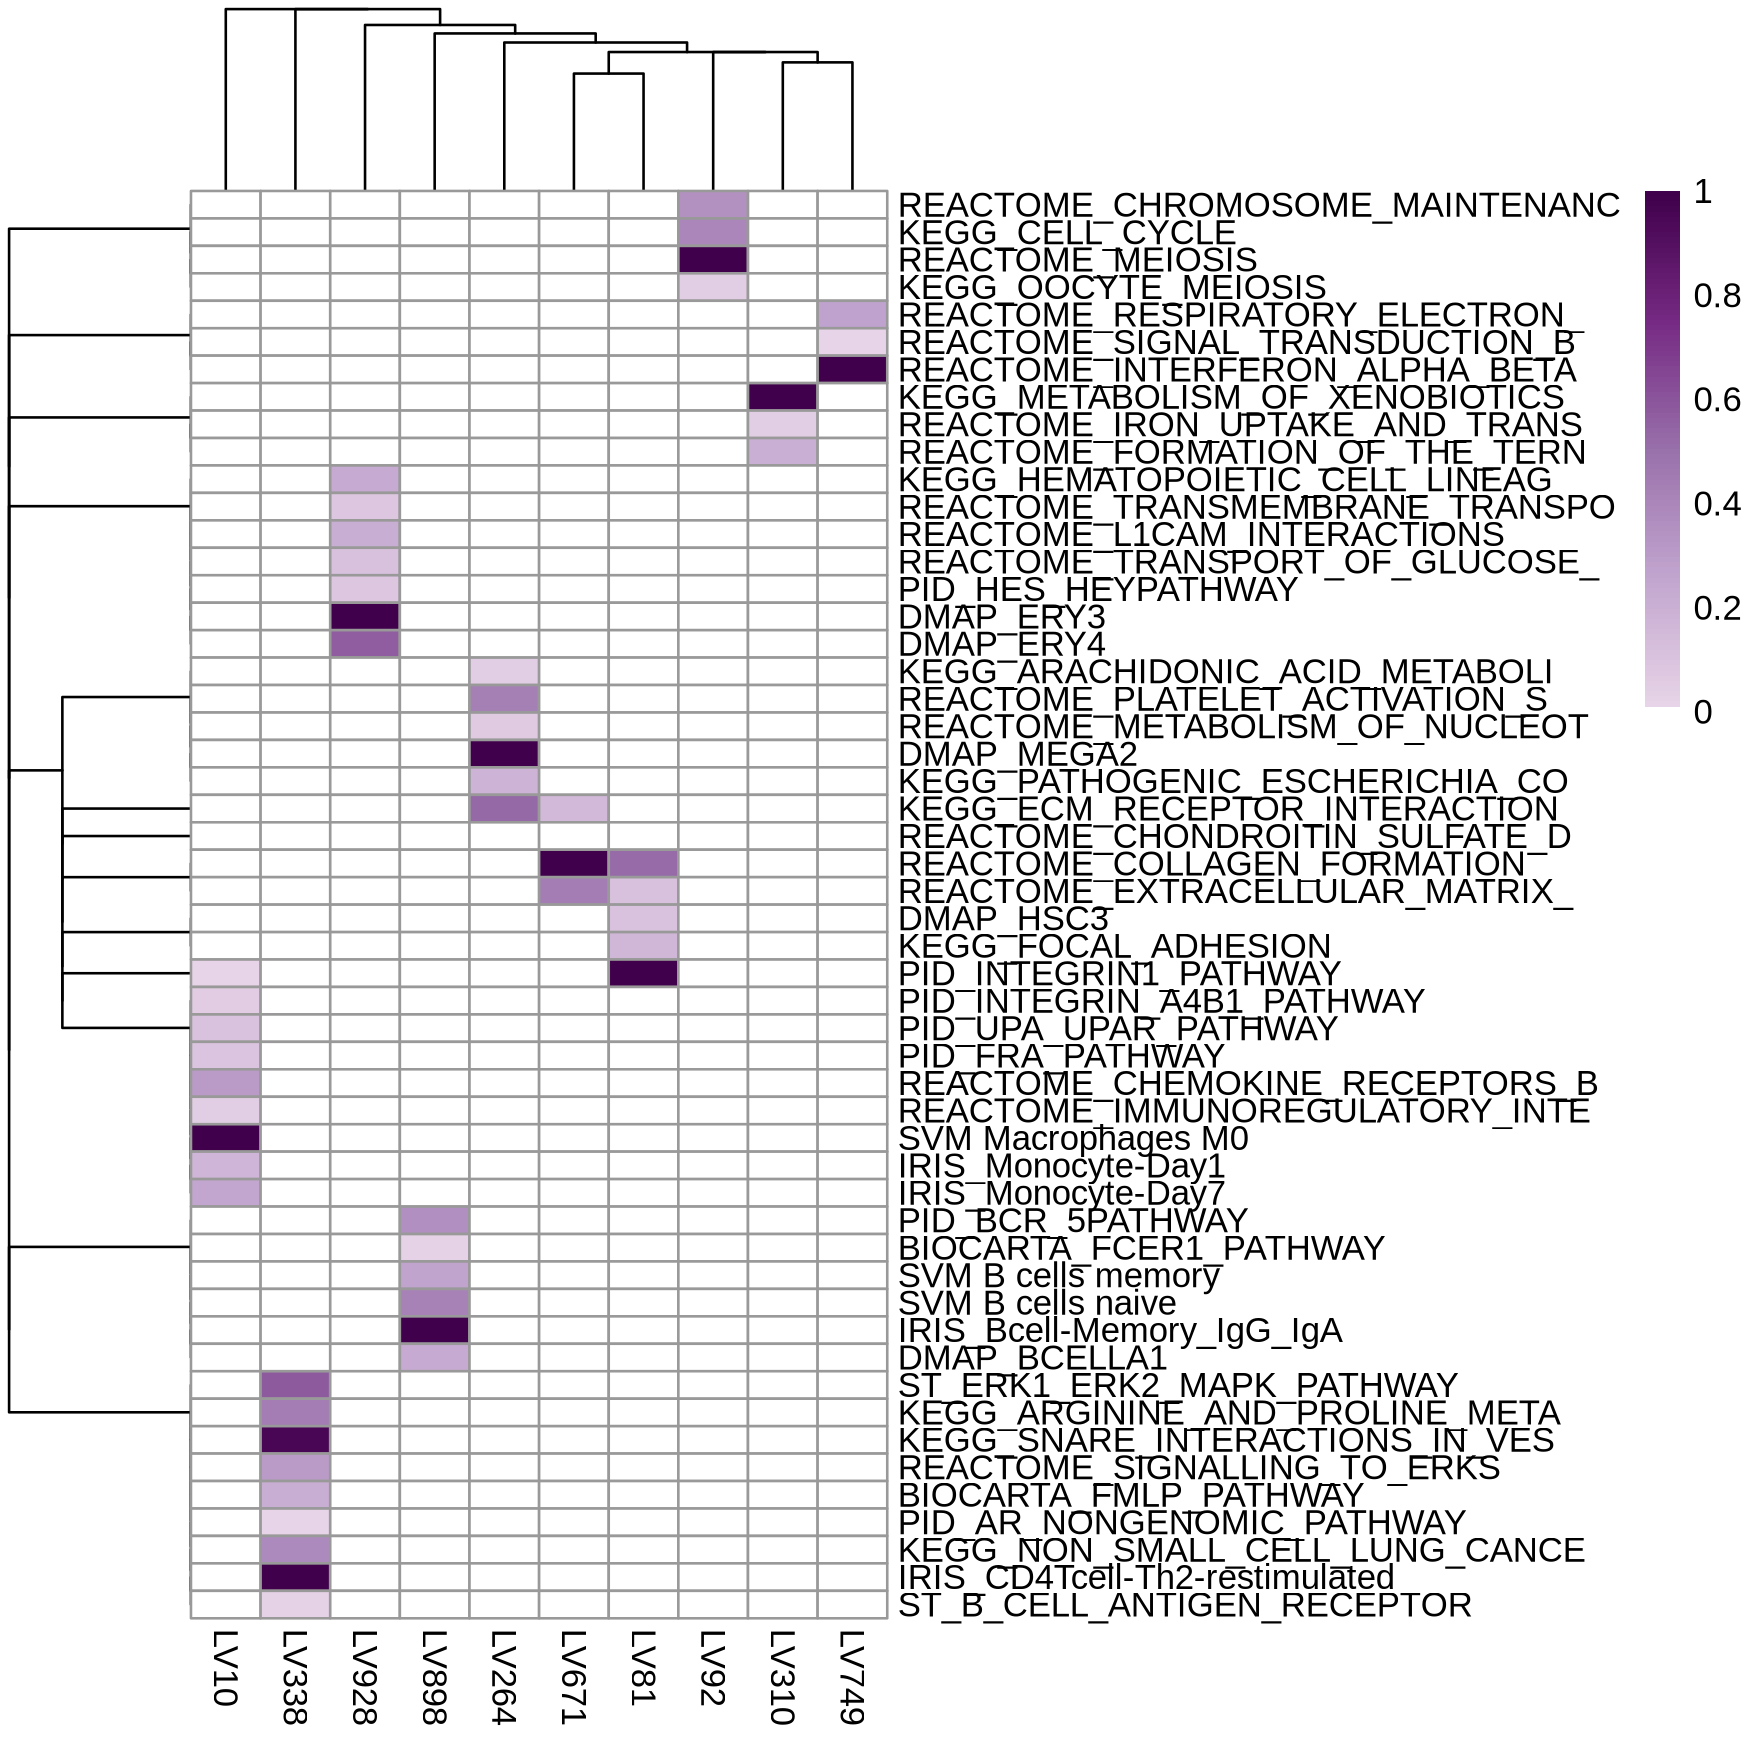

In [36]:
options(repr.plot.width = 7, repr.plot.height = 7, repr.plot.res = 250)

PLIER::plotU(plierRes = ordered_multiplier_model,
             indexCol = first_10_lv_indices,
             top = 10)

Warning message in max(plierRes$summary[plierRes$summary[, 5] < fdr.cutoff, 4]):
“no non-missing arguments to max; returning -Inf”


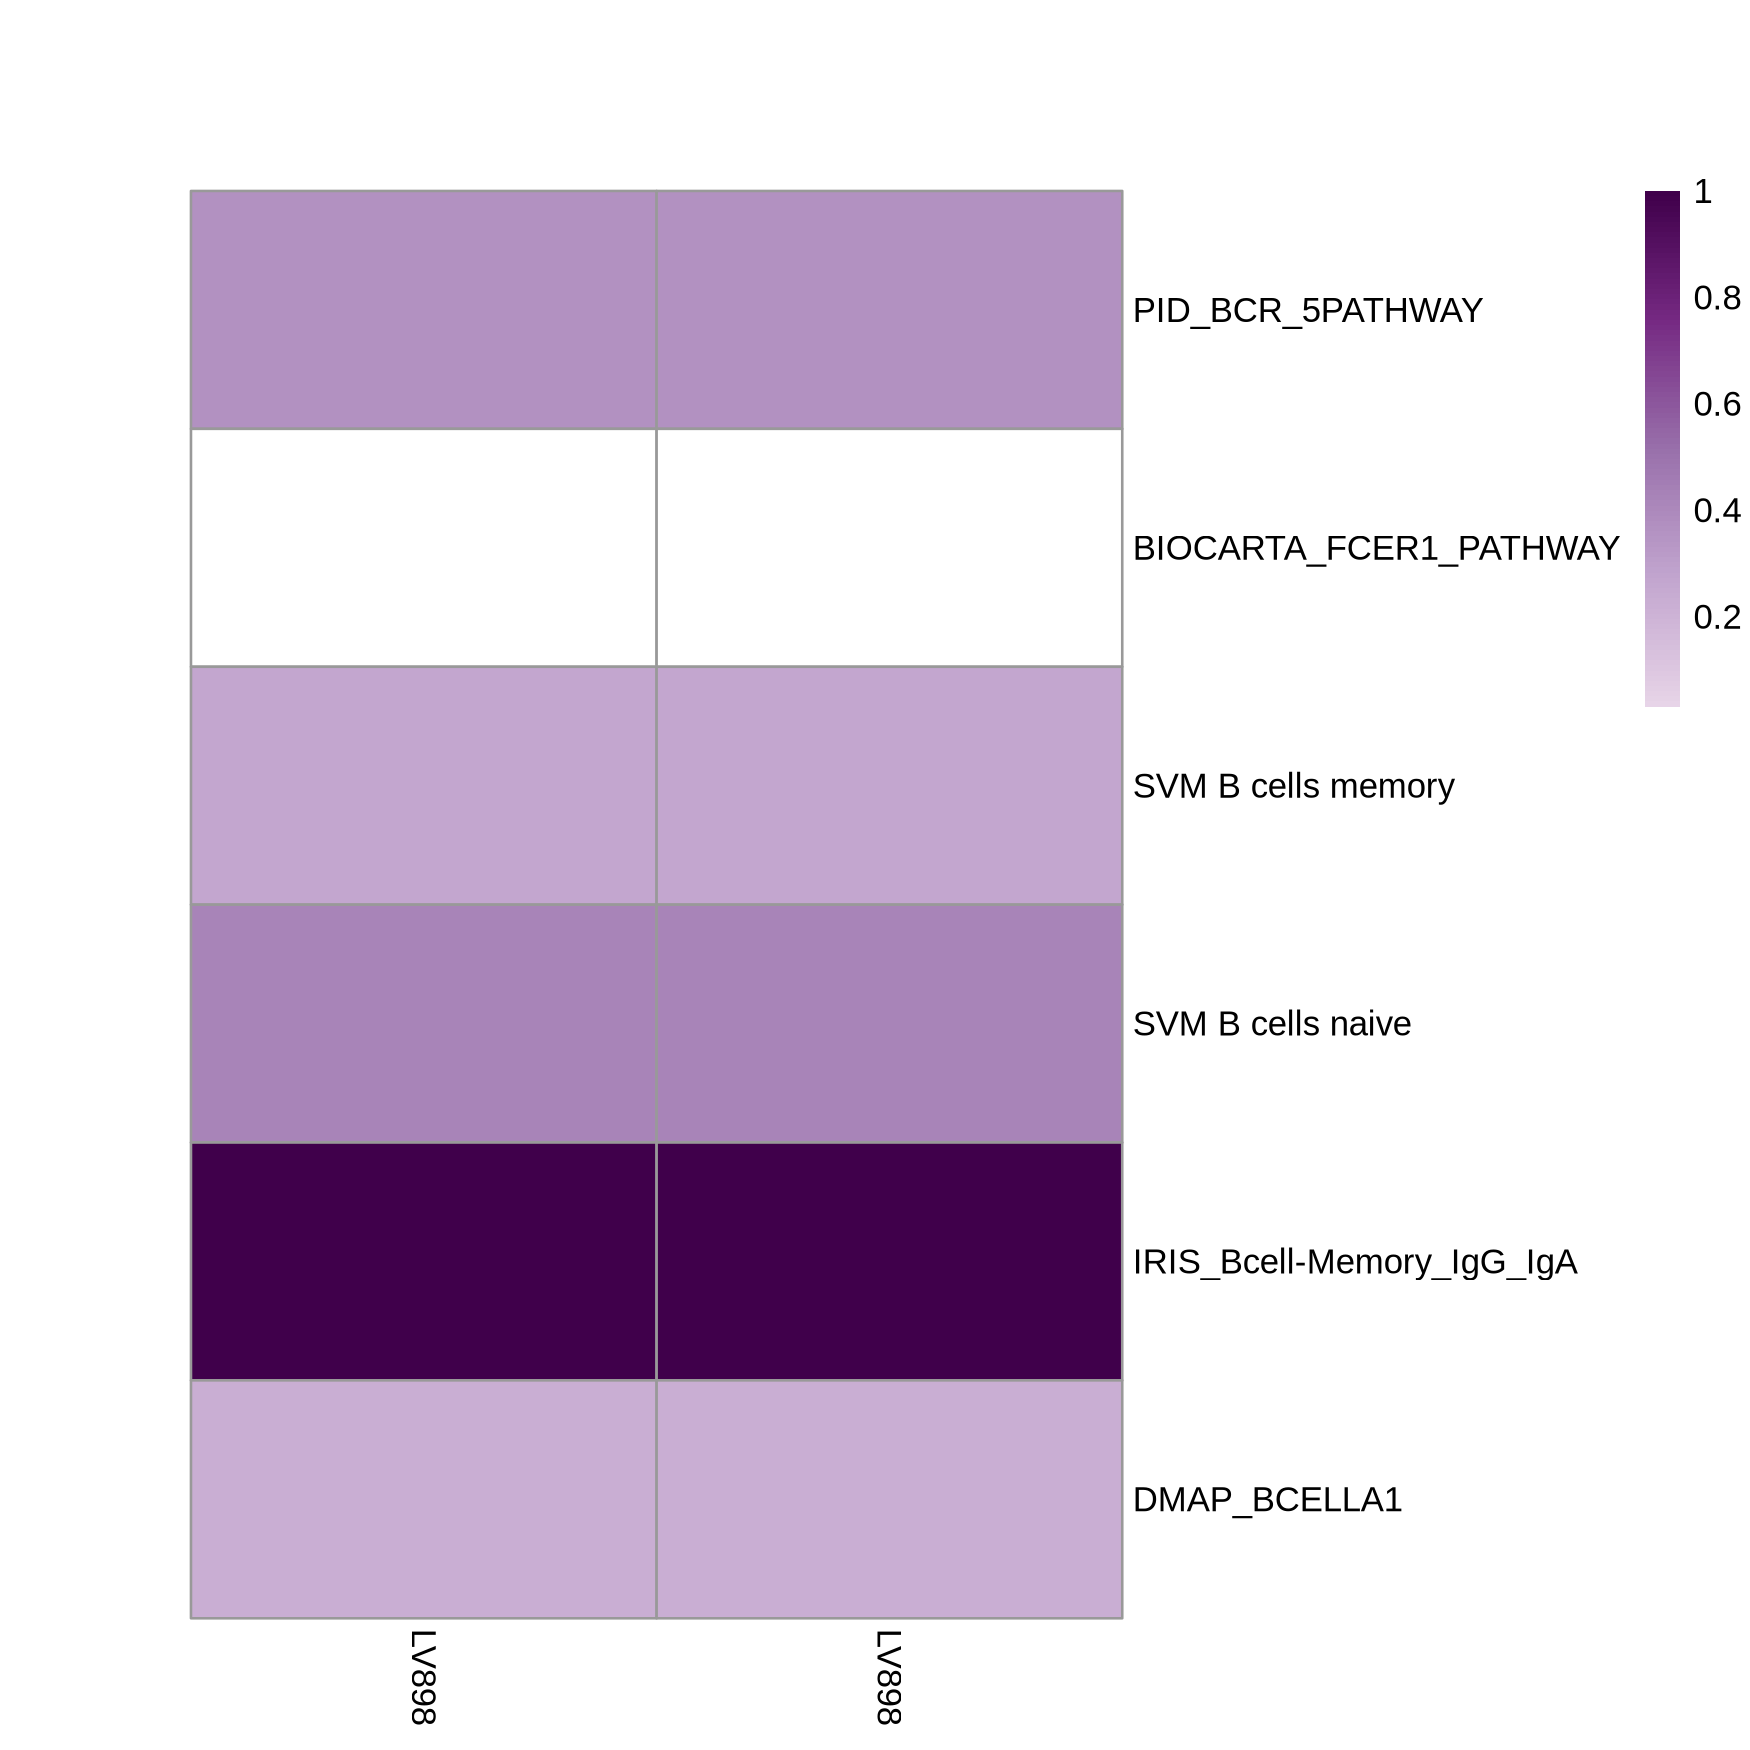

In [37]:
PLIER::plotU(plierRes = ordered_multiplier_model,
             indexCol = c(898, 898),
             top = 10)

In [38]:
head(top_int_lvs)

[1] "338" "967" "875" "149" "439" "52"

https://greenelab.github.io/multi-plier/03-isolated_cell_type_populations.nb.html

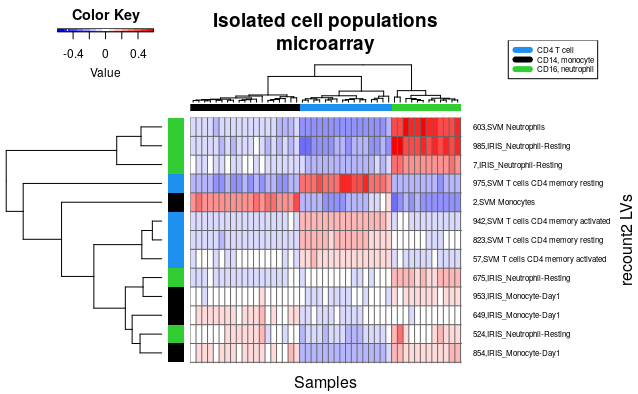

In [39]:
# Define the vector i_lv
i_lv <- first_10_lv_indices

# Extract numeric part from LV and create a new column for comparison
df_projection_GSE190125$LV_num <- as.numeric(sub(".*?(\\d+).*", "\\1", df_projection_GSE190125$LV))

# Subset the dataframe where LV_num matches the values in i_lv
df_selected <- df_projection_GSE190125[df_projection_GSE190125$LV_num %in% i_lv, ]

# Optionally, you can remove the temporary LV_num column
df_selected$LV_num <- NULL
df_projection_GSE190125$LV_num <- NULL

df_selected <- data.frame(df_selected)

# Reshape the data
long_data <- df_selected %>%
  pivot_longer(cols = -LV, names_to = "Sample", values_to = "Value") %>% 
    dplyr::left_join(metadata_GSE190125)


Joining with `by = join_by(Sample)`


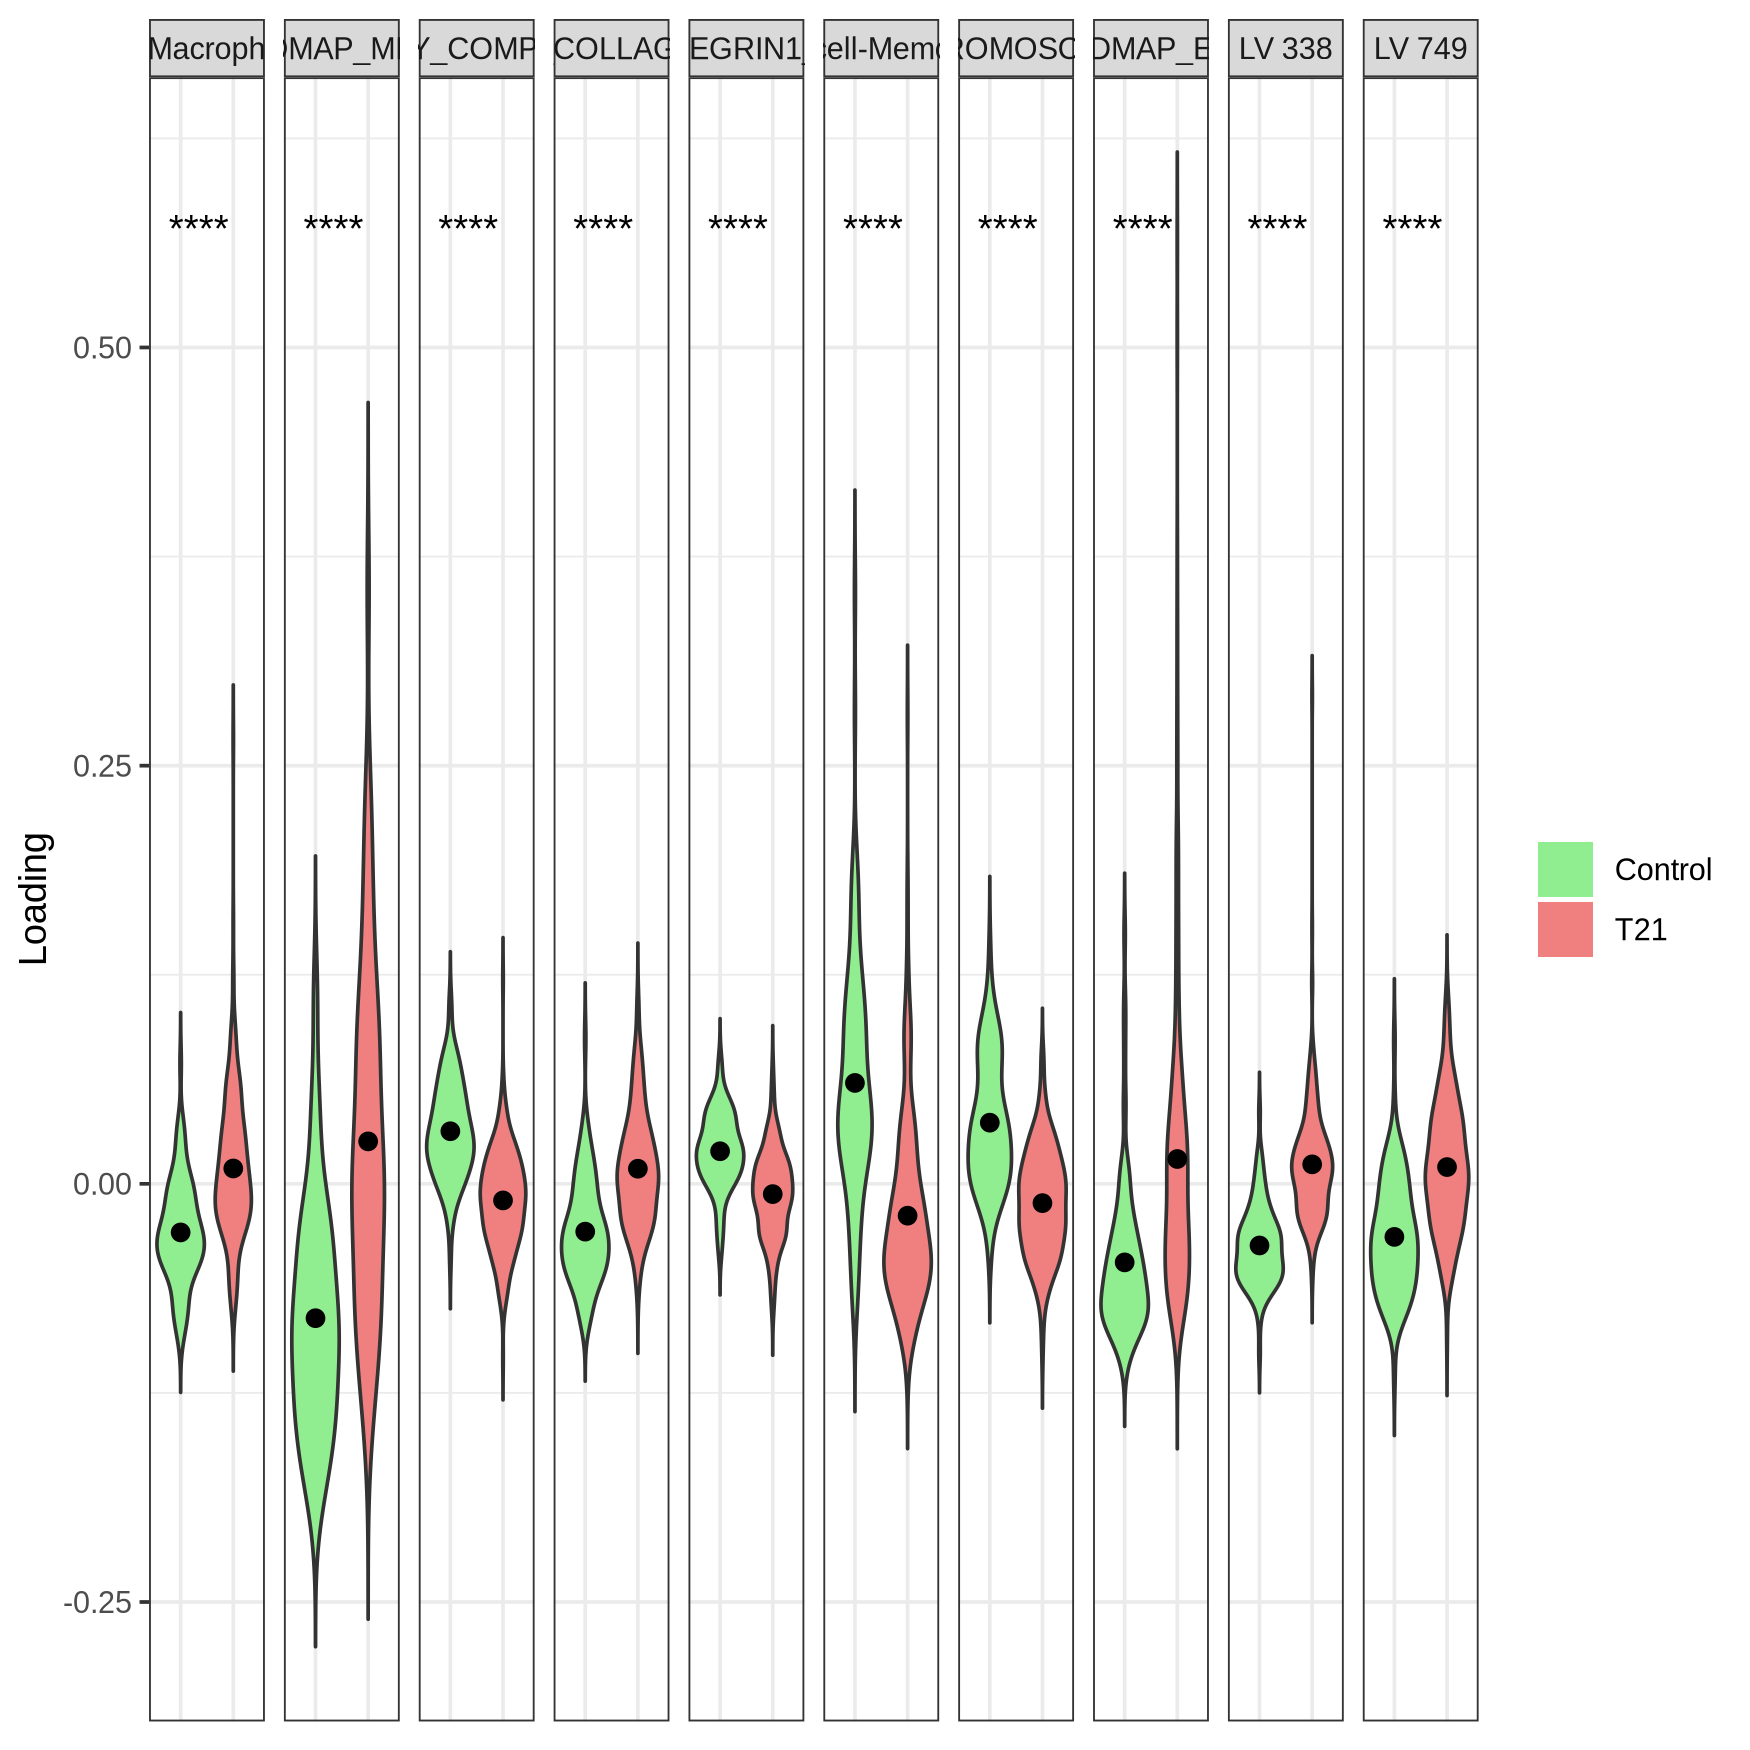

In [40]:
plot <- ggplot(long_data, aes(x = Group, y = Value, fill = Group)) +
    geom_violin(trim = FALSE) +
    stat_summary(fun = mean, geom = "point", color = "black", size = 2) +
    facet_grid(cols = vars(LV), scales = "free_x") +
    labs(x = NULL,  # Remove x-axis title
       y = "Loading") +
    theme_bw() +
    theme(axis.title.x=element_blank(),
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank(),
         legend.title = element_blank()) +
        scale_fill_manual(values = c("Control" = "lightgreen", "T21" = "lightcoral")) 
# Add statistical test and modify the legend
plot <- plot + stat_compare_means(method = "wilcox.test", label = "p.signif")

# Add a custom legend entry for mean values
plot + guides(fill = guide_legend(override.aes = list(shape = c(NA, NA), linetype = c(0, 0))),
          color = guide_legend(override.aes = list(shape = c(16), linetype = c(0), color = "black"))) 

In [41]:
# genes vs lv sig (which genes are or not sig)
# log2FC or auc
# can genes separate the data?
# add traits
# recount2 B matrix subset
# enrichment chr21 

# Join layers of information

In [42]:
f_multiplier_summary <-  multiplier_summary %>% 
dplyr::filter(FDR < 0.05 & AUC > 0.7) %>% 
rename(LV = `LV index`, m_p_value = `p-value`, m_FDR = FDR) %>% 
mutate(LV = paste0('LV', LV))

In [43]:
f_projection <- filtered_wilcox_results %>% 
dplyr::filter(p_value_adj < 0.05) %>% 
dplyr::rename(p_p_value = p_value , p_FDR = p_value_adj)  %>% 
mutate(LV = gsub(' ', '', LV))

In [44]:
phenomexcan <- readRDS('~/Downloads/gls-summary-phenomexcan.rds')

f_phenomexcan <- phenomexcan %>% 
dplyr::filter(fdr < 0.05) %>% 
dplyr::rename(t_p_value = pvalue , t_FDR = fdr, LV = lv)

In [45]:
head(f_multiplier_summary)
head(f_projection)
head(f_phenomexcan)

,pathway,LV,AUC,m_p_value,m_FDR
,<chr>,<chr>,<dbl>,<dbl>,<dbl>
1,REACTOME_MRNA_SPLICING,LV1,0.7330575,4.772691e-05,5.816211e-04
2,IRIS_Monocyte-Day0,LV2,0.8900356,4.315812e-25,1.329887e-22
3,DMAP_MONO2,LV2,0.9046759,1.313970e-16,1.574574e-14
4,DMAP_NKA1,LV2,0.9012313,1.193102e-08,3.100627e-07
5,SVM Monocytes,LV2,0.9622275,6.361913e-11,2.919712e-09
6,REACTOME_TRANSMISSION_ACROSS_CHEMICAL_SYNAPSES,LV3,0.7823614,9.532254e-08,2.164323e-06


LV,p_p_value,p_FDR
<chr>,<dbl>,<dbl>
LV338,3.220013e-33,3.178153e-30
LV149,1.973524e-31,9.739340e-29
LV239,2.546223e-30,8.377073e-28
LV967,8.166181e-29,2.015005e-26
LV439,7.351486e-28,1.451183e-25
LV869,6.950850e-27,1.143415e-24


,phenotype,phenotype_desc,LV,t_p_value,t_FDR
,<fct>,<fct>,<fct>,<dbl>,<dbl>
1974,1747_4,"Hair colour (natural, before greying): Dark brown",LV502,4.698433e-11,4.097497e-07
1975,1747_4,"Hair colour (natural, before greying): Dark brown",LV620,1.642438e-07,5.766839e-04
1976,1747_4,"Hair colour (natural, before greying): Dark brown",LV194,1.115369e-06,2.818309e-03
1977,1747_4,"Hair colour (natural, before greying): Dark brown",LV187,1.313250e-06,3.221546e-03
1978,1747_4,"Hair colour (natural, before greying): Dark brown",LV209,2.194476e-06,4.847773e-03
1979,1747_4,"Hair colour (natural, before greying): Dark brown",LV958,4.119187e-06,7.977230e-03


In [46]:
tmp_join <- inner_join(f_multiplier_summary, f_projection, by = "LV", relationship = "many-to-many")
multi_pheno_projection_GSE190125 <- inner_join(tmp_join, f_phenomexcan, by = "LV", relationship = "many-to-many")
multi_pheno_projection_GSE190125

pathway,LV,AUC,m_p_value,m_FDR,p_p_value,p_FDR,phenotype,phenotype_desc,t_p_value,t_FDR
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<dbl>
REACTOME_POTASSIUM_CHANNELS,LV32,0.7070448,0.005346682,0.02815737,8.748066e-04,1.598952e-03,22506_113,Tobacco smoking: Ex-smoker,2.964966e-05,3.500582e-02
REACTOME_POTASSIUM_CHANNELS,LV32,0.7070448,0.005346682,0.02815737,8.748066e-04,1.598952e-03,2395_4,Hair/balding pattern: Pattern 4,4.970597e-07,1.444950e-03
REACTOME_POTASSIUM_CHANNELS,LV32,0.7070448,0.005346682,0.02815737,8.748066e-04,1.598952e-03,1299,Salad / raw vegetable intake,3.748653e-05,4.145817e-02
REACTOME_POTASSIUM_CHANNELS,LV32,0.7070448,0.005346682,0.02815737,8.748066e-04,1.598952e-03,D75,Diagnoses - main ICD10: D75 Other diseases of blood and blood-forming organs,3.533929e-05,3.976968e-02
REACTOME_POTASSIUM_CHANNELS,LV32,0.7070448,0.005346682,0.02815737,8.748066e-04,1.598952e-03,20003_2038460150,Treatment/medication code: paracetamol (20003_2038460150),2.996306e-05,3.529328e-02
REACTOME_POTASSIUM_CHANNELS,LV32,0.7070448,0.005346682,0.02815737,8.748066e-04,1.598952e-03,1190,Nap during day,1.505287e-07,5.359855e-04
REACTOME_POTASSIUM_CHANNELS,LV32,0.7070448,0.005346682,0.02815737,8.748066e-04,1.598952e-03,2395_1,Hair/balding pattern: Pattern 1,1.387468e-08,6.709391e-05
REACTOME_POTASSIUM_CHANNELS,LV32,0.7070448,0.005346682,0.02815737,8.748066e-04,1.598952e-03,30140_raw,Neutrophill count,1.013250e-05,1.596924e-02
REACTOME_POTASSIUM_CHANNELS,LV32,0.7070448,0.005346682,0.02815737,8.748066e-04,1.598952e-03,1950,Sensitivity / hurt feelings,4.042441e-05,4.366702e-02


In [47]:
colnames(multi_pheno_projection_GSE190125)

[1] "pathway"        "LV"             "AUC"            "m_p_value"     
 [5] "m_FDR"          "p_p_value"      "p_FDR"          "phenotype"     
 [9] "phenotype_desc" "t_p_value"      "t_FDR"

In [48]:
options(repr.matrix.max.rows = Inf, repr.data.frame.max.rows = Inf)

multi_pheno_projection_GSE190125 %>% 
dplyr::select(LV, pathway, phenotype_desc) 

LV,pathway,phenotype_desc
<chr>,<chr>,<fct>
LV32,REACTOME_POTASSIUM_CHANNELS,Tobacco smoking: Ex-smoker
LV32,REACTOME_POTASSIUM_CHANNELS,Hair/balding pattern: Pattern 4
LV32,REACTOME_POTASSIUM_CHANNELS,Salad / raw vegetable intake
LV32,REACTOME_POTASSIUM_CHANNELS,Diagnoses - main ICD10: D75 Other diseases of blood and blood-forming organs
LV32,REACTOME_POTASSIUM_CHANNELS,Treatment/medication code: paracetamol (20003_2038460150)
LV32,REACTOME_POTASSIUM_CHANNELS,Nap during day
LV32,REACTOME_POTASSIUM_CHANNELS,Hair/balding pattern: Pattern 1
LV32,REACTOME_POTASSIUM_CHANNELS,Neutrophill count
LV32,REACTOME_POTASSIUM_CHANNELS,Sensitivity / hurt feelings


In [49]:
unique(multi_pheno_projection_GSE190125[c('pathway')])

,pathway
,<chr>
1,REACTOME_POTASSIUM_CHANNELS
17,KEGG_NOD_LIKE_RECEPTOR_SIGNALING_PATHWAY
24,PID_IL23PATHWAY
31,SVM Dendritic cells activated
43,SVM Eosinophils
55,REACTOME_MUSCLE_CONTRACTION
71,REACTOME_ACTIVATION_OF_ATR_IN_RESPONSE_TO_REPLICATION_STRESS
76,DMAP_PRE_BCELL2
86,PID_NFAT_3PATHWAY


In [50]:
multiplier_summary %>% 
dplyr::filter(`LV index` %in% '83') %>%
dplyr::filter(FDR < 0.05 & AUC > 0.7) 

pathway,LV index,AUC,p-value,FDR
<chr>,<chr>,<dbl>,<dbl>,<dbl>
SVM Dendritic cells activated,83,0.7086632,0.003368070,0.01947702
SVM Eosinophils,83,0.7098881,0.004663367,0.02525646


In [51]:
multi_pheno_projection_GSE190125 %>% 
dplyr::select(LV, pathway, phenotype_desc) %>% 
dplyr::filter(LV == 'LV83')

LV,pathway,phenotype_desc
<chr>,<chr>,<fct>
LV83,SVM Dendritic cells activated,"Non-cancer illness code, self-reported: ankylosing spondylitis"
LV83,SVM Dendritic cells activated,Spondylopathies (FG)
LV83,SVM Dendritic cells activated,"Non-cancer illness code, self-reported: psoriasis"
LV83,SVM Dendritic cells activated,Illnesses of adopted mother: None of the above (group 1)
LV83,SVM Dendritic cells activated,Methods of self-harm used: Ingesting a medication in excess of the normal dose
LV83,SVM Dendritic cells activated,Bronchitis
LV83,SVM Dendritic cells activated,Mean platelet (thrombocyte) volume
LV83,SVM Dendritic cells activated,Treatment/medication code: dovobet ointment (20003_1141179992)
LV83,SVM Dendritic cells activated,"Non-cancer illness code, self-reported: psoriatic arthropathy"


In [52]:
unique(multi_pheno_projection_GSE190125$LV)

[1] "LV32"  "LV35"  "LV83"  "LV111" "LV154" "LV195" "LV358" "LV376" "LV397"
[10] "LV436" "LV456" "LV526" "LV530" "LV598" "LV607" "LV749" "LV762" "LV828"
[19] "LV837" "LV853" "LV913" "LV914" "LV931" "LV962"

Joining with `by = join_by(Sample)`


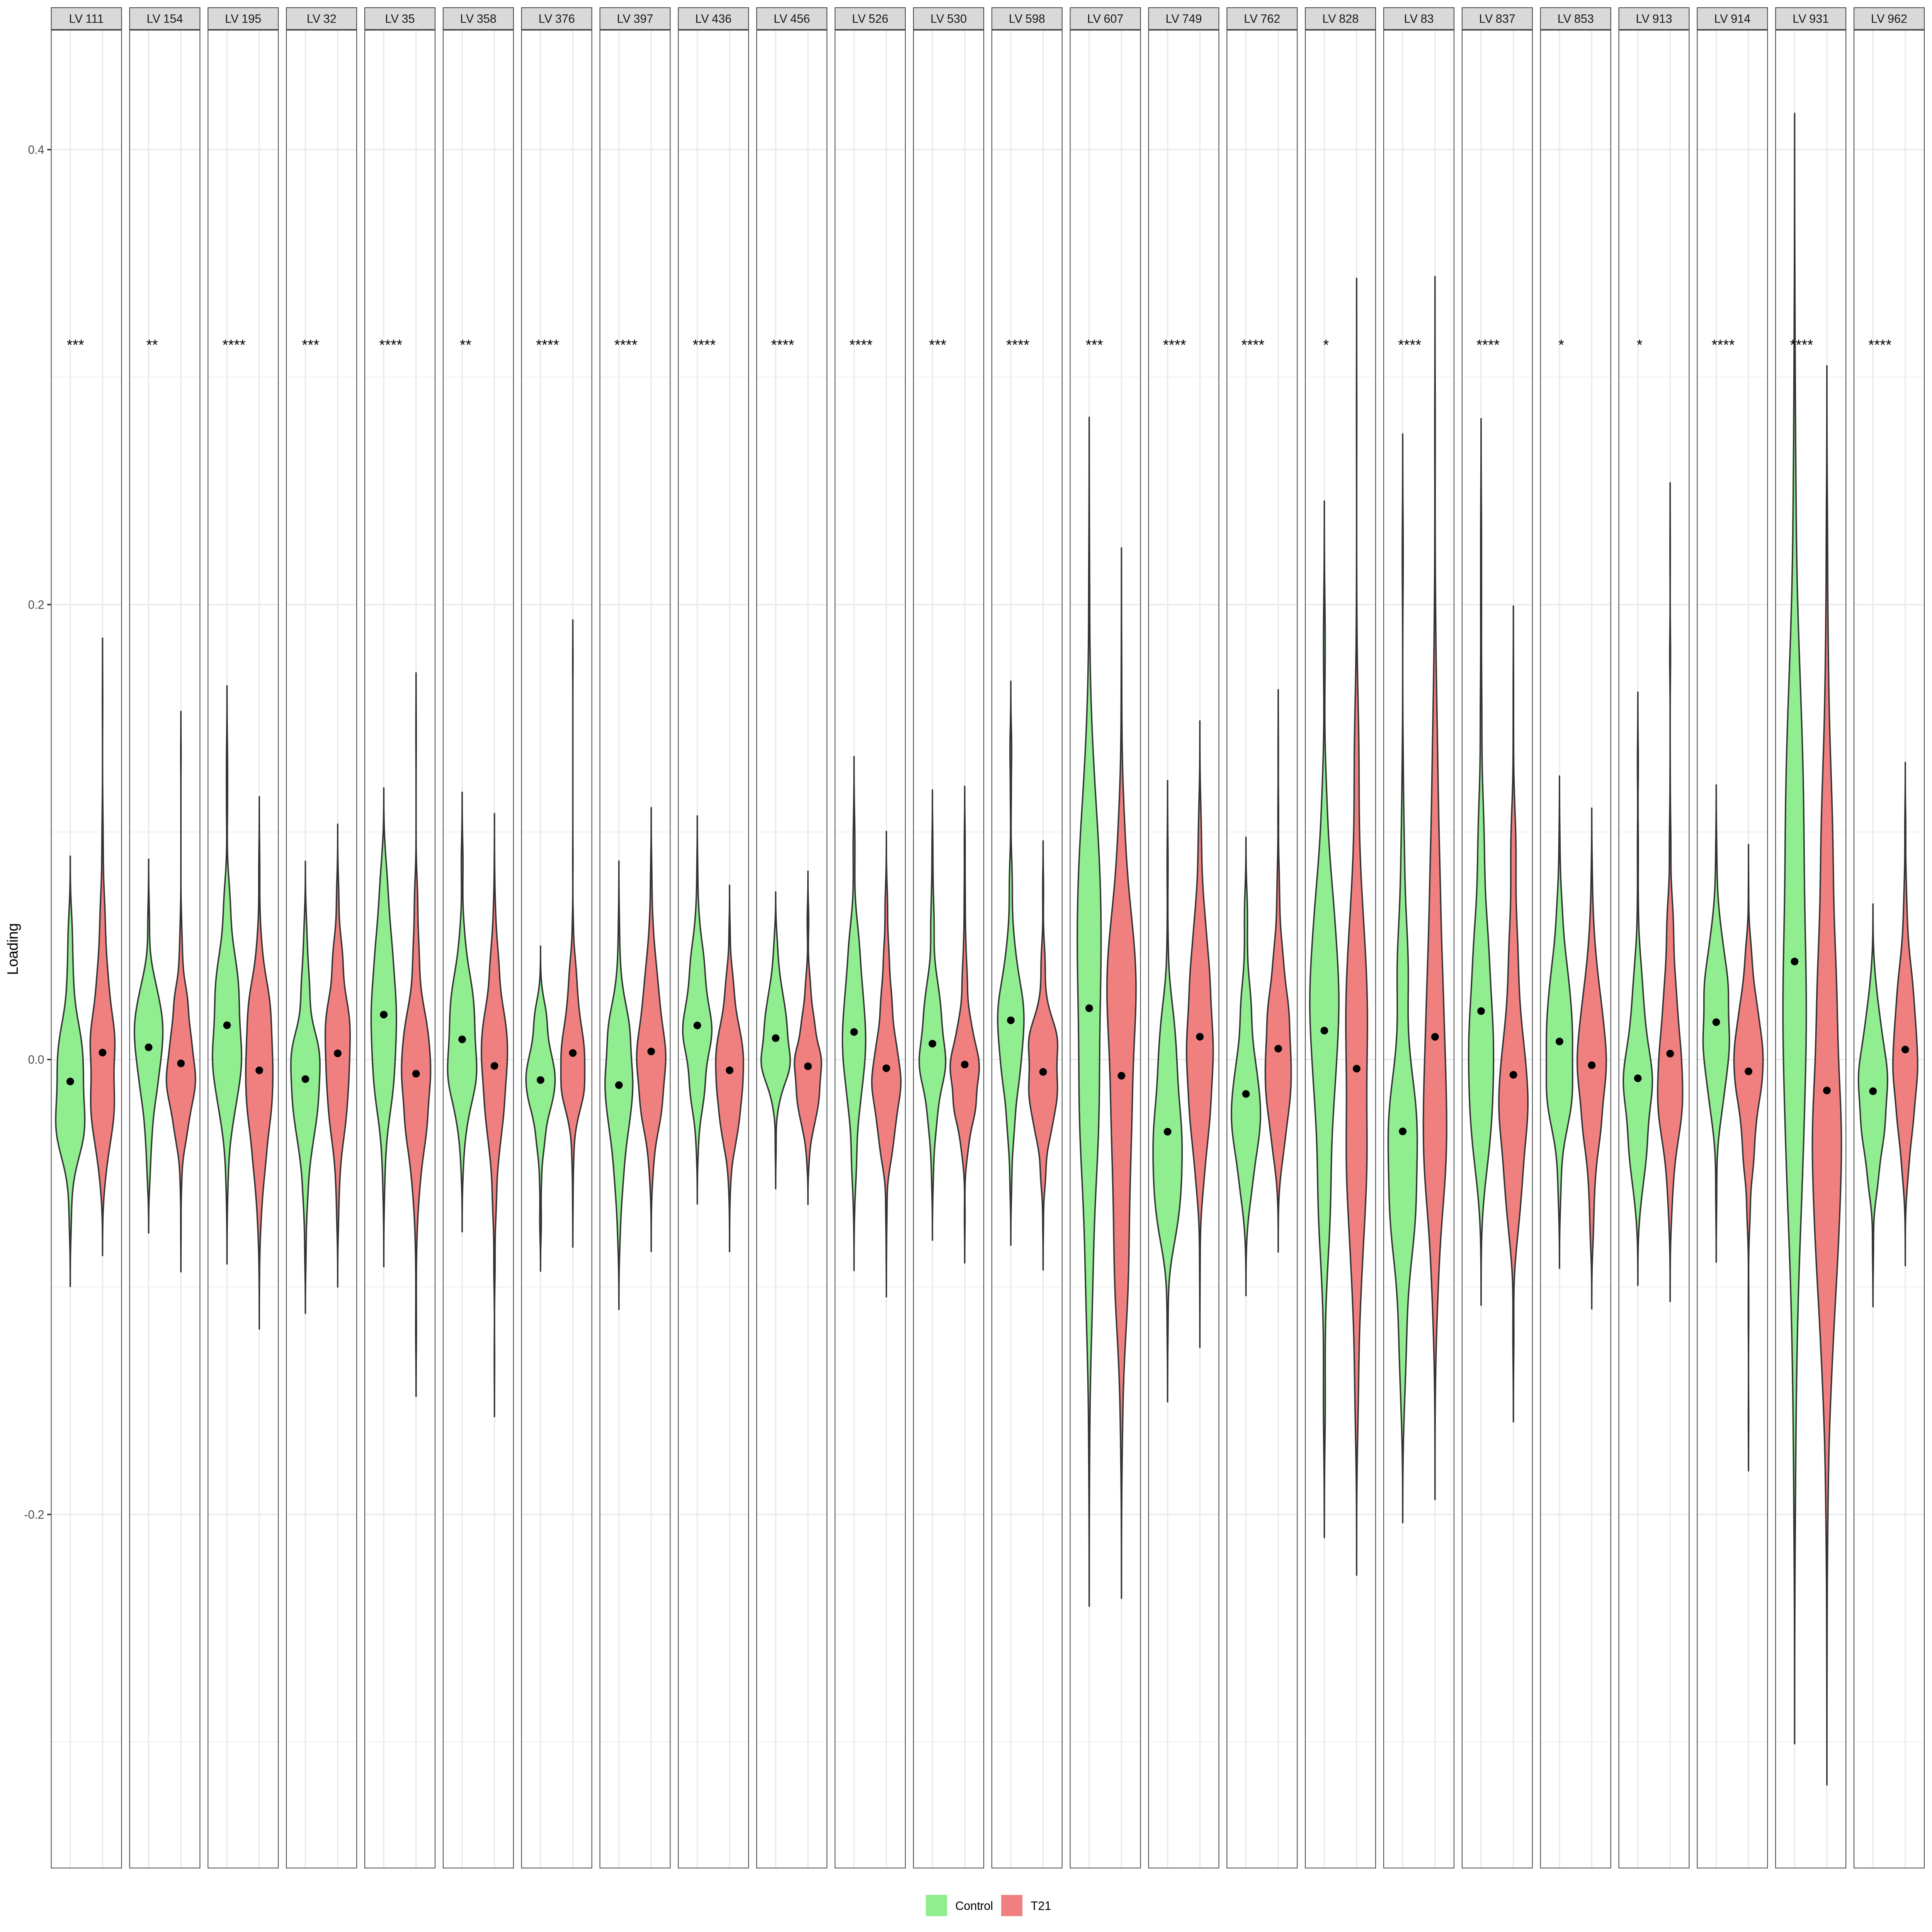

In [53]:
options(repr.plot.width = 20, repr.plot.height = 20, repr.plot.res = 250)

# Define the vector i_lv
i_lv <- gsub('LV', '', unique(multi_pheno_projection_GSE190125$LV))

# Extract numeric part from LV and create a new column for comparison
df_projection_GSE190125$LV_num <- as.numeric(sub(".*?(\\d+).*", "\\1", df_projection_GSE190125$LV))

# Subset the dataframe where LV_num matches the values in i_lv
df_selected <- df_projection_GSE190125[df_projection_GSE190125$LV_num %in% i_lv, ]

# Optionally, you can remove the temporary LV_num column
df_selected$LV_num <- NULL
df_projection_GSE190125$LV_num <- NULL

df_selected <- data.frame(df_selected)

# Reshape the data
long_data <- df_selected %>%
  pivot_longer(cols = -LV, names_to = "Sample", values_to = "Value") %>% 
    dplyr::left_join(metadata_GSE190125)

plot <- ggplot(long_data, aes(x = Group, y = Value, fill = Group)) +
    geom_violin(trim = FALSE) +
    stat_summary(fun = mean, geom = "point", color = "black", size = 2) +
    facet_grid(cols = vars(LV), scales = "free_x") +
    labs(x = NULL,  # Remove x-axis title
       y = "Loading") +
    theme_bw() +
    theme(axis.title.x=element_blank(),
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank(),
          legend.position = "bottom",
         legend.title = element_blank()) +
        scale_fill_manual(values = c("Control" = "lightgreen", "T21" = "lightcoral")) 
# Add statistical test and modify the legend
plot <- plot + stat_compare_means(method = "wilcox.test", label = "p.signif")

# Add a custom legend entry for mean values
plot + guides(fill = guide_legend(override.aes = list(shape = c(NA, NA), linetype = c(0, 0))),
          color = guide_legend(override.aes = list(shape = c(16), linetype = c(0), color = "black"))) 

In [54]:
diff_lvs <- long_data %>%
  mutate(LV = gsub(' ', '', LV)) %>%
  group_by(LV, Group) %>%
  summarize(mean_value = mean(Value, na.rm = TRUE)) 

head(diff_lvs)

`summarise()` has grouped output by 'LV'. You can override using the `.groups` argument.


LV,Group,mean_value
<chr>,<chr>,<dbl>
LV111,Control,-0.009648482
LV111,T21,0.003046889
LV154,Control,0.005367952
LV154,T21,-0.001695143
LV195,Control,0.015072839
LV195,T21,-0.004759844


In [55]:
diff_lvs <- long_data %>%
  mutate(LV = gsub(' ', '', LV)) %>%
  group_by(LV, Group) %>%
  summarize(mean_value = mean(Value, na.rm = TRUE)) %>%
  pivot_wider(names_from = Group, values_from = mean_value) %>%
  mutate(
    higher_group = case_when(
      Control > T21 ~ "Control",
      T21 > Control ~ "T21",
      TRUE ~ "Equal"
    ) 
  )

head(diff_lvs)

`summarise()` has grouped output by 'LV'. You can override using the `.groups` argument.


LV,Control,T21,higher_group
<chr>,<dbl>,<dbl>,<chr>
LV111,-0.009648482,0.003046889,T21
LV154,0.005367952,-0.001695143,Control
LV195,0.015072839,-0.004759844,Control
LV32,-0.008610039,0.002718960,T21
LV35,0.019736996,-0.006232736,Control
LV358,0.008852349,-0.002795479,Control


In [86]:
multi_pheno_projection_GSE190125 %>% 
dplyr::left_join(diff_lvs) %>% 
dplyr::select(LV, pathway, phenotype_desc, higher_group) %>% 
select(LV) %>%  unique() %>%  nrow()

Joining with `by = join_by(LV)`


[1] 24

In [57]:
multi_pheno_projection_GSE190125 %>% 
dplyr::filter(LV == 'LV32')

pathway,LV,AUC,m_p_value,m_FDR,p_p_value,p_FDR,phenotype,phenotype_desc,t_p_value,t_FDR
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<dbl>
REACTOME_POTASSIUM_CHANNELS,LV32,0.7070448,0.005346682,0.02815737,0.0008748066,0.001598952,22506_113,Tobacco smoking: Ex-smoker,2.964966e-05,3.500582e-02
REACTOME_POTASSIUM_CHANNELS,LV32,0.7070448,0.005346682,0.02815737,0.0008748066,0.001598952,2395_4,Hair/balding pattern: Pattern 4,4.970597e-07,1.444950e-03
REACTOME_POTASSIUM_CHANNELS,LV32,0.7070448,0.005346682,0.02815737,0.0008748066,0.001598952,1299,Salad / raw vegetable intake,3.748653e-05,4.145817e-02
REACTOME_POTASSIUM_CHANNELS,LV32,0.7070448,0.005346682,0.02815737,0.0008748066,0.001598952,D75,Diagnoses - main ICD10: D75 Other diseases of blood and blood-forming organs,3.533929e-05,3.976968e-02
REACTOME_POTASSIUM_CHANNELS,LV32,0.7070448,0.005346682,0.02815737,0.0008748066,0.001598952,20003_2038460150,Treatment/medication code: paracetamol (20003_2038460150),2.996306e-05,3.529328e-02
REACTOME_POTASSIUM_CHANNELS,LV32,0.7070448,0.005346682,0.02815737,0.0008748066,0.001598952,1190,Nap during day,1.505287e-07,5.359855e-04
REACTOME_POTASSIUM_CHANNELS,LV32,0.7070448,0.005346682,0.02815737,0.0008748066,0.001598952,2395_1,Hair/balding pattern: Pattern 1,1.387468e-08,6.709391e-05
REACTOME_POTASSIUM_CHANNELS,LV32,0.7070448,0.005346682,0.02815737,0.0008748066,0.001598952,30140_raw,Neutrophill count,1.013250e-05,1.596924e-02
REACTOME_POTASSIUM_CHANNELS,LV32,0.7070448,0.005346682,0.02815737,0.0008748066,0.001598952,1950,Sensitivity / hurt feelings,4.042441e-05,4.366702e-02


In [63]:
df_multiplier_z <- data.frame(multiplier_z)

In [78]:
df_multiplier_z %>%
dplyr::select(X962) %>% 
mutate(X962 = as.numeric(X962)) %>% 
arrange(desc(X962)) %>%
slice(1:ceiling(0.1 * n())) %>% 
rownames() %>% 
unique() %>% 
write.table(quote = FALSE, row.names = FALSE, col.names = FALSE)

MYH11
ACTG2
ACTA2
PPP1R12B
SYNPO2
CALD1
LMOD1
MYLK
KCNMB1
SORBS1
DES
DMD
RAB23
MYL9
CACNA1C
ITGA1
TPM1
TNS1
LPP
TPM2
PALLD
MYL6B
MYL6
FLNA
FBXO32
KCNMA1
BAG2
CACNA1H
TPM4
CRISPLD2
RBPMS
TACR2
STON1
MGP
TLN1
MRVI1
CALM2
CALM1
SVIL
TNNC2
ATP2B4
GEM
NEB
TSPAN2
PPP1R14A
SEMG1
CALM3
PARVA
SORBS3
TNNT1
PDLIM7
SLC24A3
ARHGEF25
ACPP
SLC22A3
TNNI2
PPP1R12A
RAMP1
MYL12B
TNNC1
TPM3
FERMT2
IGF1
TCAP
TNNI3
OXTR
ITGB5
AVPR1A
POTEM
TACC1
DIXDC1
MYL4
TEAD3
PDE4D
PDE5A
CEBPD
ADCY5
PTGER3
TGFB3
TIMP3
ARHGAP6
PRKCA
ITGA5
ASB2
ALDH1B1
FANCC
ROCK2
ILK
COL4A2
NKD1
MICAL3
VCL
TAGLN
EEF2K
A2M
PARM1
PSD
ADAMTS1
THBS4
FOXO1
COL15A1
KAT5
ARHGAP10
ZNF248
LYVE1
TAF10
KCNK6
ITPR1
SRF
BCL2L2
ZDHHC14
RHOB
ROCK1
CSPG4
DPYSL3
TSPAN18
HEPH
ARHGEF11
PDK4
SLC14A1
RAMP3
SPSB1
HSPB1
HPSE2
KCNMB3
VIPR2
COL4A1
CUX1
BRAF
SSPN
NRP2
MITF
NUMA1
ARHGEF17
DUSP3
ITGA9
NR4A1
C1S
TGM2
OR52K1
MICAL2
CA3
FOSL2
ITPR2
GNA11
SMG6
NID1
KCNMB4
PPP1R3B
TRAF5
PLA2G4A
ZFHX3
SERPING1
GUCY1A3
ACTB
ZBTB16
TGFB1I1
MYH9
GPD1L
CTGF
PPP1CB
TTN
ZNF354A

In [91]:
lv_enrich=333
lv_enrich=paste0('X', lv_enrich)

data.frame(multiplier_z) %>%
dplyr::select(lv_enrich) %>%
dplyr::mutate(lv_enrich = as.numeric(lv_enrich)) %>% 
arrange(desc(lv_enrich)) %>%
slice(1:ceiling(0.1 * n())) %>% 
rownames() %>% 
unique() %>% 
write.table(quote = FALSE, row.names = FALSE, col.names = FALSE)

Warning message:
“There was 1 warning in `dplyr::mutate()`.
ℹ In argument: `lv_enrich = as.numeric(lv_enrich)`.
Caused by warning:
! NAs introduced by coercion”


In [73]:
lv_enrich=32
top_1_percent_column_913 <- data.frame(multiplier_z) %>%
  dplyr::select(X913) %>%
  arrange(desc(X913)) %>%
  slice(1:ceiling(0.1 * n()))



top_1_percent_column_913 %>% 
rownames() %>% 
unique() %>% 
write.table(quote = FALSE, row.names = FALSE, col.names = FALSE)

PLA2G2D
IGKC
CCL19
DERL3
NOS2
CXCL13
OLFM4
C1QB
MZB1
IGHM
MADCAM1
CR2
TNFRSF6B
ADAMDEC1
C2
C1QC
CASP5
GMDS
TMEM176B
C1S
C1QA
TMEM176A
GABBR1
TAP1
UGT2B17
PIGR
CD74
ACSL5
IGLL1
RARRES3
MEOX1
RAMP3
KCNE3
LCN2
GGT5
SLC40A1
GUCY2C
CFB
VPREB3
TFF3
CASP10
XBP1
ANPEP
DNASE1L3
SERPING1
CETP
CLDN15
TAP2
COL15A1
CPA3
GBP3
STAT1
PSMB8
MMP12
SLAMF8
NR1I2
ETS2
CCL18
CLDN7
KCNQ1
FCGBP
RELB
PLCB3
CTSH
PDZK1IP1
CXCL9
CASP1
LAP3
LGALS3BP
MYO7B
IL15RA
BACE2
TNFRSF14
SULT1B1
CXCL6
PSMB10
HEPH
MMP1
C1R
APOL6
GRK5
BCL2L14
PSMB9
B3GNT3
ACVRL1
CEACAM1
CD1D
FCRL5
STAT3
FOXP3
IFI27
COL18A1
TIFAB
SCO2
CSF1
TPSAB1
SSR4
MEP1A
CD27
BTNL8
A2M
VNN1
CFH
SOCS3
SLC7A9
DLL1
CD55
LILRB5
GJA4
NR1H3
PTGFR
NAGS
TYMP
CD72
IL12RB1
BAK1
VILL
SLC35C1
GNA11
TAPBP
PAOX
MUC1
IGLL3P
LGALS2
SLC44A3
C3
TTC38
SLC39A5
WARS
PSME2
DHRS11
ENPP2
IRF9
SOCS1
CD19
SERPINB6
AKR1C3
ARSA
CLIC2
NOXO1
MS4A2
DGAT1
JAK3
ACHE
AIRE
COL7A1
CD4
SMPDL3A
UBA7
PLXDC1
TNFSF12
CXCL16
STARD5
LAG3
EPHB2
CXCR6
AGMAT
NOX1
CRISPLD2
IL18BP
SPIB
MLEC
KREMEN1
ALDH2


In [72]:
# Load necessary libraries
library(clusterProfiler)
library(org.Hs.eg.db)
library(TxDb.Hsapiens.UCSC.hg38.knownGene)

# Prepare your gene list
gene_list <- c("PLA2G2D", "IGKC", "CCL19", "DERL3", "NOS2", "CXCL13", "OLFM4", 
               "C1QB", "MZB1", "IGHM", "MADCAM1", "CR2", "TNFRSF6B", "ADAMDEC1", 
               "C2", "C1QC", "CASP5", "GMDS", "TMEM176B")

# Annotate genes with chromosomal locations
txdb <- TxDb.Hsapiens.UCSC.hg38.knownGene
genes <- genes(txdb)
gene_coords <- as.data.frame(genes)
gene_coords <- gene_coords[gene_coords$gene_id %in% gene_list, ]

# Create a gene-to-chromosome mapping
gene_to_chrom <- gene_coords[, c("gene_id", "seqnames")]
colnames(gene_to_chrom) <- c("gene", "chromosome")

# Create a list of gene sets by chromosome
chromosome_gene_sets <- split(gene_to_chrom$gene, gene_to_chrom$chromosome)

# Perform enrichment analysis
enrichment_results <- enricher(gene_list, TERM2GENE = chromosome_gene_sets)

# Convert enrichment results to data frame for visualization
enrichment_df <- as.data.frame(enrichment_results)

# Check the first few rows of the results
head(enrichment_df)

# Visualize results
barplot(enrichment_results, showCategory=10)


  2135 genes were dropped because they have exons located on both strands
  of the same reference sequence or on more than one reference sequence,
  so cannot be represented by a single genomic range.
  Use 'single.strand.genes.only=FALSE' to get all the genes in a
  GRangesList object, or use suppressMessages() to suppress this message.

--> No gene can be mapped....

--> Expected input gene ID: 

--> return NULL...



<0 x 0 matrix>

ERROR: Error in barplot.default(enrichment_results, showCategory = 10): 'height' must be a vector or a matrix


In [ ]:
# Function to calculate gene enrichment across chromosomes
genome <- function(gene_data, background_data) {
# Ensure both gene_data and background_data have columns: chromosome_name and start_position
if (!all(c("chromosome_name", "start_position") %in% colnames(gene_data)) ||
    !all(c("chromosome_name", "start_position") %in% colnames(background_data))) {
  stop("Data must have columns: chromosome_name and start_position")
}

# Calculate the number of genes per chromosome in the gene list
gene_freq <- table(gene_data$chromosome_name)

# Calculate the number of genes per chromosome in the background data
background_freq <- table(background_data$chromosome_name)

# Ensure chromosomes are in the same order
all_chromosomes <- union(names(gene_freq), names(background_freq))
gene_freq <- gene_freq[all_chromosomes]
background_freq <- background_freq[all_chromosomes]

# Perform the enrichment test
enrichment_results <- data.frame(
  chromosome = all_chromosomes,
  gene_count = as.numeric(gene_freq),
  background_count = as.numeric(background_freq),
  p_value = sapply(all_chromosomes, function(chrom) {
    phyper(
      gene_freq[chrom] - 1, 
      background_freq[chrom], 
      sum(background_freq) - background_freq[chrom], 
      sum(gene_freq), 
      lower.tail = FALSE
    )
  })
)

# Adjust p-values for multiple testing
enrichment_results$p_adjusted <- p.adjust(enrichment_results$p_value, method = "fdr")

return(enrichment_results)
}